<a href="https://colab.research.google.com/github/JoseDrube/B-Cell-Epitope-Prediction/blob/main/Trabajo_Final_Data_Science_Ingles_Drube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting B-Cell Epitopes Using Machine Learning on SARS-CoV-2 Peptide Data**

## Introduction

With the emergence of COVID-19, a new exploratory field arose focused on the development of vaccines capable of reducing the mortality caused by this virus during the pandemic. Although several vaccines have already been developed to treat SARS-CoV-2, the identification of novel epitopes that can be recognized as antigens remains a critical task. This is particularly relevant in the case of the emergence of new viral variants due to mutations that may alter existing antigenic regions.

In this context, the application of machine learning models enables the efficient identification of candidate epitopes, significantly reducing both the temporal and financial costs associated with experimental approaches. Moreover, computational epitope prediction facilitates a faster and more scalable response to newly emerging variants, supporting ongoing efforts in vaccine design and immunological research.

Key Concepts

- Antigen:
Any foreign molecule or substance (such as bacteria, viruses, or pollen) that is recognized by the immune system and capable of triggering an immune response.

- Epitope:
The specific and localized portion of an antigen—typically a short amino acid or carbohydrate sequence—that is directly recognized by antibodies or immune cells. Epitopes represent the precise targets of the immune response, and a single antigen may contain multiple distinct epitopes.

## Executive Summary

## Objective

The primary objective of this project is to develop and evaluate machine learning models capable of predicting B-cell epitopes based on physicochemical and structural features of peptide sequences. Accurate epitope prediction is a critical step in immunoinformatics, as it enables the prioritization of antigenic regions for experimental validation, vaccine design, and immunological studies. Given the high cost and time constraints of experimental approaches, computational models provide an efficient strategy to identify candidate epitopes while minimizing false negatives.

## Methodology

**Data:**
The analysis was conducted using curated peptide and protein datasets derived from experimentally annotated B-cell epitopes, including SARS and SARS-CoV-2–related sequences. The dataset comprises peptide-level physicochemical features, positional information, and protein-level descriptors.

**Preprocessing & Feature Engineering:**
A feature engineering process was performed, incorporating biologically meaningful properties from existing features, some are: flexibility, peptide length, and relative position within the parent protein. Feature distributions were explored through exploratory data analysis (EDA), revealing non-normality, skewness, and the presence of biologically relevant extreme values, most of them were preserved rather than removed.

**Modeling:**
Multiple supervised learning algorithms were evaluated, including Logistic Regression (baseline), Random Forest, XGBoost, and a Multilayer Perceptron (MLP). Also, hierarchical clustering was applied as an unsupervised approach to explore the way the data is structured. With this information a cluster feature was incorporated to be used in the classification models.

**Validation Strategy:**
The most valued metric for this project was recall of the positive class (epitopes), complemented by F1-score and ROC-AUC. Cross-validation and stratified train–test splits were used to ensure reliable performance estimation.

## Key Results

Tree-based ensemble models demonstrated better performance compared to linear and neural network approaches. The Random Forest classifier optimized via GridSearchCV achieved the best results, having a good balance between sensitivity and overall performance, reaching a high recall for the epitope class while maintaining a strong ROC-AUC. These results indicate that, in this case, non-linear models are better suited for the complex relationships in the epitope formation in peptide sequences.

## Data Description

Information regarding whether an amino acid peptide exhibited antibody-inducing activity was obtained from the Immune Epitope Database (IEDB). This information was used as the labeling data for the classification task. In addition, candidate epitope amino acid sequences (peptides) and their corresponding activity labels were extracted from the B-cell epitope datasets provided by the IEDB.

The antibody isotypes considered in this study were restricted to IgG, as this class represents the most frequently reported antibody type within the IEDB. For consistency and to avoid redundancy, records corresponding to multiple quantitative measurements of antibody activity for the same peptide within experimental assays were excluded.

The epitope data retrieved from the IEDB comprised five categories of antibody activity:

Positive-High

Positive-Intermediate

Positive-Low

Positive

Negative

However, due to the limited number of samples labeled as Positive-High, Positive-Intermediate, and Positive-Low, these categories were treated equivalently and grouped under a single Positive class. Consequently, the problem was formulated as a binary classification task, distinguishing between peptides with antibody-inducing activity (Positive) and those without (Negative).

## Dataset Content

The dataset consists of three data files:

- input_bcell.csv:
This is the primary training dataset. It contains 14,387 rows, corresponding to all combinations of 14,362 peptides and 757 parent proteins.

- input_sars.csv:
This dataset is also used as part of the training data and contains 520 rows.

- input_covid.csv:
This dataset represents the target (prediction) data and does not include labeled target values.

### Features

All three datasets contain information related to proteins and peptides, including the following variables:

- parent_protein_id: Identifier of the parent protein

- protein_seq: Amino acid sequence of the parent protein

- start_position: Starting position of the peptide within the parent protein

- end_position: Ending position of the peptide within the parent protein

- peptide_seq: Amino acid sequence of the peptide

Peptide-level features

- chou_fasman: Peptide feature related to β-turn propensity

- emini: Peptide feature representing relative surface accessibility

- kolaskar_tongaonkar: Peptide feature related to antigenicity

- parker: Peptide feature representing hydrophobicity

Protein-level features

- isoelectric_point: Isoelectric point of the parent protein

- aromaticity: Aromaticity of the parent protein

- hydrophobicity: Hydrophobicity of the parent protein

- stability: Stability index of the parent protein

The bcell and sars datasets include antibody valence information, which is used as the target variable:

- target: Antibody-inducing activity (target variable)

Engineered Features

In addition to the original variables, the following features were created:

- peptide_length: Length of the peptide sequence

- hydrophobic_ratio: Ratio of hydrophobic amino acids in the peptide

- flexible_ratio: Ratio of flexible amino acids in the peptide

- aromatic_ratio: Ratio of aromatic amino acids in the peptide

- relative_position: Relative position of the peptide within the parent protein

- parker_per_aa: Parker hydrophobicity normalized by peptide length

Information and dataset were obtained from the following link:

https://www.kaggle.com/datasets/futurecorporation/epitope-prediction/data


# **Imports**

In [ ]:
pip install umap-learn kneed

In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np
import random
from typing import List, Dict, Any
from abc import ABC, abstractmethod
from itertools import combinations

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D


# Modelos y Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import cycle, islice
from sklearn import cluster
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.neural_network import MLPClassifier


# Métricas de evaluación para clustering
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.metrics import (classification_report, recall_score, roc_auc_score, confusion_matrix, silhouette_score, accuracy_score,
                             average_precision_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples,
                             mean_absolute_error, roc_curve, auc, mean_squared_error, r2_score)

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

## Analytics

In [ ]:
def find_and_display_duplicates(df_data):
    """
    Identifica y muestra las filas duplicadas en un DataFrame.

    Args:
        df_data (pd.DataFrame): El DataFrame a revisar.
    """
    duplicated_rows = df_data[df_data.duplicated(keep=False)]

    if not duplicated_rows.empty:
        print(f"Se encontraron {len(duplicated_rows)}")
    else:
        print("No se encontraron filas duplicadas.")
    return duplicated_rows

In [ ]:
def separate_columns_by_type(df):
    """
    Separa las columnas de un DataFrame en listas de columnas numéricas y categóricas/discretas.
    Considera una columna numérica como discreta si tiene un tipo entero y un número limitado de valores únicos.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.

    Returns:
        tuple: Un par de listas (categorical_cols, numerical_cols).
    """
    categorical_cols = []
    numerical_cols = []

    for col in df.columns:
        # Excluir la columna 'type' si es de tipo object/category y ya se sabe que es categórica
        if col == 'type':
            categorical_cols.append(col)
            continue

        if pd.api.types.is_numeric_dtype(df[col]):
            # Heurística para columnas numéricas discretas (enteros con pocos valores únicos)
            if pd.api.types.is_integer_dtype(df[col]) and df[col].nunique() < 20:
                # Si es un entero y tiene menos de 20 valores únicos, podría ser discreta/categórica
                # 'quality' es un buen ejemplo aquí
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        else:
            # Todo lo demás (object, category) es tratado como categórico
            categorical_cols.append(col)

    return categorical_cols, numerical_cols

In [ ]:
def clean_outliers_iqr(df_data, column_names, iqr_multiplier=1.5):
    """
    Limpia outliers en columnas numéricas usando el método IQR (Interquartile Range).
    Los outliers se reemplazan por los límites inferior y superior calculados (capping).

    Args:
        df_data (pd.DataFrame): El DataFrame que contiene los datos.
        column_names (list): Una lista de cadenas con los nombres de las columnas a limpiar.
        iqr_multiplier (float): Multiplicador para el IQR para definir los límites de los outliers.
                                  Un valor común es 1.5.

    Returns:
        pd.DataFrame: Un nuevo DataFrame con los outliers limpiados.
    """
    df_cleaned = df_data.copy()
    for col in column_names:
        if pd.api.types.is_numeric_dtype(df_cleaned[col]):
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - (iqr_multiplier * IQR)
            upper_bound = Q3 + (iqr_multiplier * IQR)

            # Capping: Reemplazar valores fuera de los límites
            df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"Outliers limpiados (capping) en la columna '{col}'.")
        else:
            print(f"La columna '{col}' no es numérica, se omite la limpieza de outliers.")
    return df_cleaned

In [ ]:
def inspect_nunique(df, cols_a_inspeccionar):
    """
    Inspecciona y imprime los valores únicos de una lista de columnas
    en un DataFrame. Muestra los valores solo si hay 100 o menos.

    Args:
        df (pd.DataFrame): El DataFrame a inspeccionar (ej. df_pulido).
        cols_a_inspeccionar (list): Lista de nombres de columnas.
    """
    for col in cols_a_inspeccionar:
        print("-" * 60)

        # 1. Verificar si la columna existe en el DataFrame
        if col in df.columns:
            unique_values = df[col].unique()
            num_unique = len(unique_values)

            print(f"--- Columna: '{col}' ({num_unique} valores únicos) ---")

            # 2. Imprimir los valores o la advertencia
            if num_unique > 100:
                print(f"ADVERTENCIA: La columna '{col}' tiene {num_unique} valores únicos. (Demasiados para mostrar).")
            else:
                # Utilizamos .tolist() y mostramos las primeras 100 entradas si fuera necesario
                print(unique_values)

        else:
            print(f"❌ Advertencia: La columna '{col}' NO se encuentra en el DataFrame.")

    print("-" * 60)

In [ ]:
def evaluar_k_clustering(data, max_k):
    """
    Calcula 4 métricas de clustering para un rango de K y devuelve los resultados.
    """
    # K must be at least 2 for Silhouette, Calinski-Harabasz, and Davies-Bouldin scores.
    k_range = range(2, max_k + 1)

    # Listas para almacenar los scores de cada métrica
    inercia_scores = []
    silueta_scores = []
    calinski_scores = []
    davies_bouldin_scores = []

    print(f"Evaluando K desde 2 hasta {max_k}...")

    for k in k_range:
        # Entrenar el modelo K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        labels = kmeans.labels_

        # Calcular y guardar las 4 métricas
        inercia_scores.append(kmeans.inertia_)
        silueta_scores.append(silhouette_score(data, labels))
        calinski_scores.append(calinski_harabasz_score(data, labels))
        davies_bouldin_scores.append(davies_bouldin_score(data, labels))

    # Crear un DataFrame con los resultados
    resultados_df = pd.DataFrame({
        'K': list(k_range),
        'Inercia': inercia_scores,
        'Silueta': silueta_scores,
        'Calinski-Harabasz': calinski_scores,
        'Davies-Bouldin': davies_bouldin_scores
    }).set_index('K')

    return resultados_df

In [ ]:
def evaluate_pc_pairs_silhouette(data, n_components_to_keep=6, k=3):
    # 1. Calculamos las componentes principales necesarias
    pca = PCA(n_components=n_components_to_keep, random_state=42)
    pca_data = pca.fit_transform(data)

    # 2. Generar todas las combinaciones de a 2 de los índices de las componentes
    # Ejemplo: si n_components=4, pares = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
    idx_components = list(range(n_components_to_keep))
    pairs = list(combinations(idx_components, 2))

    results = []

    for i, j in pairs:
        # Extraemos solo las 2 componentes seleccionadas
        pair_data = pca_data[:, [i, j]]

        # Aplicamos KMeans sobre ese par
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(pair_data)

        # Calculamos Silhouette
        score = silhouette_score(pair_data, labels)

        results.append({
            'PC_A': f'PC{i}',
            'PC_B': f'PC{j}',
            'Pair': f'PC{i} vs PC{j}',
            'Silhouette': score
        })

    return pd.DataFrame(results).sort_values(by='Silhouette', ascending=False)

## Graphs

In [ ]:
def plot_categorical_distribution(df_data, column_name):
    """
    Genera un gráfico de conteo para visualizar la distribución de una columna categórica.

    Args:
        df_data (pd.DataFrame): El DataFrame que contiene los datos.
        column_name (str): El nombre de la columna categórica a graficar.
    """
    plt.figure(figsize=(7, 5))
    sns.countplot(x=column_name, data=df_data, hue=column_name, legend=False)
    plt.title(f'Distribución de {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Conteo')
    plt.show()

In [ ]:
def plot_numerical_distributions(df_data, column_names):
    """
    Genera histogramas con estimación de densidad de kernel (KDE) para múltiples columnas numéricas.
    La función ajusta automáticamente el diseño de la cuadrícula de los gráficos.

    Args:
        df_data (pd.DataFrame): El DataFrame que contiene los datos.
        column_names (list): Una lista de cadenas con los nombres de las columnas a graficar.
    """
    num_plots = len(column_names)

    if num_plots == 0:
        print("No se proporcionaron columnas para graficar.")
        return

    if num_plots == 1:
        nrows, ncols = 1, 1
    elif num_plots == 2:
        nrows, ncols = 1, 2
    else: # For 3 or more plots, aim for 2 columns per row
        nrows = (num_plots + 1) // 2
        ncols = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    fig.suptitle('Distribución de Características Numéricas', fontsize=16)

    # Aplanar los ejes para facilitar la iteración si hay múltiples filas/columnas
    if num_plots == 1:
        axes_flat = [axes]
    else:
        axes_flat = axes.flatten()

    for i, col in enumerate(column_names):
        if i < len(axes_flat):
            sns.histplot(df_data[col], kde=True, ax=axes_flat[i], color='teal')
            axes_flat[i].set_title(f'Distribución de {col}')
            axes_flat[i].set_xlabel(col)
            axes_flat[i].set_ylabel('Frecuencia')

    # Ocultar ejes vacíos si los hay
    for j in range(num_plots, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def plot_outliers_boxplot(df_data, column_names):
    """
    Genera diagramas de caja (box plots) para visualizar outliers en columnas numéricas.
    La función ajusta automáticamente el diseño de la cuadrícula.

    Args:
        df_data (pd.DataFrame): El DataFrame que contiene los datos.
        column_names (list): Una lista de cadenas con los nombres de las columnas a graficar.
    """
    num_plots = len(column_names)

    if num_plots == 0:
        print("No se proporcionaron columnas para graficar los outliers.")
        return

    # Determinar el número de filas y columnas para el subplots grid
    if num_plots == 1:
        nrows, ncols = 1, 1
    elif num_plots == 2:
        nrows, ncols = 1, 2
    elif num_plots <= 4:
        nrows, ncols = 2, 2
    else:
        nrows = (num_plots + 1) // 3  # Intentar 3 columnas por fila para más de 4
        ncols = 3

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    fig.suptitle('Visualización de Outliers con Box Plots', fontsize=16)

    # Aplanar los ejes para facilitar la iteración
    if num_plots == 1:
        axes_flat = [axes]
    else:
        axes_flat = axes.flatten()

    for i, col in enumerate(column_names):
        if i < len(axes_flat):
            sns.boxplot(y=df_data[col], ax=axes_flat[i], color='lightsteelblue')
            axes_flat[i].set_title(f'Box Plot de {col}')
            axes_flat[i].set_ylabel(col)

    # Ocultar ejes vacíos si los hay
    for j in range(num_plots, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_labels, model_name="Modelo"):
    """
    Genera un heatmap de la matriz de confusión.

    y_true: etiquetas reales
    y_pred: predicciones del modelo
    class_labels: lista o array con los nombres de las clases (ej. ['0', '1'] o ['red', 'white'])
    model_name: string con el nombre del modelo para el título
    """
    # 1. Calcular la matriz
    cm = confusion_matrix(y_true, y_pred)

    # 2. Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels,
                cbar=True)

    # 3. Estética y etiquetas
    plt.xlabel('Clase Predicha', fontsize=12)
    plt.ylabel('Clase Verdadera', fontsize=12)
    plt.title(f'Matriz de Confusión: {model_name}', fontsize=14, pad=20)

    # Corregir posible corte en los bordes (común en algunas versiones de matplotlib)
    plt.tight_layout()
    plt.show()

# plot_custom_confusion_matrix(y_test, y_pred_rf, best_rf_model.classes_, "Random Forest GSCV")

In [ ]:
def plot_custom_roc_curve(model, X_test, y_test, pos_label, model_name="Modelo"):
    """
    Calcula y grafica la curva ROC y el AUC para un modelo dado.
    """
    # 1. Obtener probabilidades para la clase positiva
    # Verificamos si el modelo tiene predict_proba (la mayoría de clasificadores)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        # Para modelos como SVM lineal que usan decision_function
        y_score = model.decision_function(X_test)

    # 2. Calcular FPR, TPR y Thresholds
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=pos_label)

    # 3. Calcular el área bajo la curva (AUC)
    roc_auc = auc(fpr, tpr)

    # 4. Graficar
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC {model_name} (AUC = {roc_auc:.4f})')

    # Línea base (azar)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Ratio Falsos Positivos (FPR)')
    plt.ylabel('Ratio Verdaderos Positivos (TPR / Recall)')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    return roc_auc

In [ ]:
def plot_corr_matrix(df, figsize=(10, 8), cmap='coolwarm', annot=True):
    """
    Genera un mapa de calor para la matriz de correlación de un DataFrame,
    mostrando solo el triángulo inferior y con una escala de color.

    Args:
        df (pd.DataFrame): El DataFrame para calcular la correlación.
        figsize (tuple): Tamaño de la figura (ancho, alto).
        cmap (str): Mapa de colores para el mapa de calor (ej. 'coolwarm', 'viridis', 'RdBu').
        annot (bool): Si es True, anota los valores de correlación en el mapa de calor.
    """
    # Seleccionar solo columnas numéricas para la correlación
    df_numeric = df.select_dtypes(include=['number'])

    # Calcular la matriz de correlación
    corr_matrix = df_numeric.corr()

    # Crear una máscara para el triángulo superior
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        mask=mask,             # Aplicar la máscara para el triángulo superior
        cmap=cmap,             # Mapa de colores
        annot=annot,           # Anotar los valores
        fmt=".2f",             # Formato de las anotaciones
        linewidths=.5,         # Líneas entre celdas
        cbar_kws={'shrink': .8} # Ajustar la barra de color
    )
    plt.title('Matriz de Correlación (Triángulo Inferior)', fontsize=16)
    plt.show()

In [ ]:
def plot_all_feature_importances(model, feature_names, top_n=None, model_name="Modelo de Ensamblaje"):
    """
    Calcula, ordena y grafica la importancia de las características de un modelo
    basado en árboles. Por defecto, grafica todas las características.

    Args:
        model: El modelo entrenado que tiene un atributo .feature_importances_.
        feature_names (list or pd.Index): Nombres de las características (columnas de X).
        top_n (int, optional): Número de características principales a mostrar.
                               Si es None (por defecto), se muestran todas.
        model_name (str, optional): Nombre del modelo para usar en el título del gráfico.

    Returns:
        pd.DataFrame: DataFrame con todas las características y sus importancias ordenadas.
    """

    # 1. Obtener la importancia de las features y realizar validaciones
    if not hasattr(model, 'feature_importances_'):
        print(f"Error: El modelo {model_name} no tiene el atributo '.feature_importances_'.")
        return pd.DataFrame()

    feature_importances = model.feature_importances_

    if len(feature_names) != len(feature_importances):
        print("Error: La longitud de los nombres de las features no coincide con la longitud de la importancia.")
        return pd.DataFrame()

    # 2. Crear un DataFrame y ordenar
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Ordenar por importancia de forma descendente
    features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    # 3. Determinar qué características plotear
    if top_n is None:
        features_to_plot = features_df
        plot_count = len(features_df)
    else:
        features_to_plot = features_df.head(top_n)
        plot_count = top_n

    # Si la importancia es cero para todas, no hay nada que graficar
    if features_to_plot['Importance'].sum() == 0:
        print(f"Todas las características en el top {plot_count} tienen una importancia de cero.")
        return features_df


    # 4. Visualización de la importancia de las características
    # Ajuste dinámico del tamaño de la figura en base al número de features
    fig_height = max(6, plot_count * 0.4)
    plt.figure(figsize=(10, fig_height))

    # Usamos sns.barplot
    sns.barplot(x='Importance', y='Feature', data=features_to_plot, palette='magma')

    # 5. Configurar título y etiquetas
    title_suffix = f'Top {plot_count} ' if top_n is not None else 'Todas las '
    plt.title(f'{title_suffix}Importancia de Características: {model_name}', fontsize=14)
    plt.xlabel('Importancia (Gini/Ganancia)', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 6. Imprimir el resumen y retornar el DataFrame completo
    print(f"\nCaracterísticas (ordenadas por importancia) para {model_name}:")
    print(features_df.head(plot_count))

    return features_df

In [ ]:
def plot_decision_boundary(model, X, y, f1_idx=0, f2_idx=2, scaler=None):
    """
    model: El modelo entrenado (ej. MLPClassifier).
    X: DataFrame o array con las features (usualmente X_test o X_train).
    y: Serie o array con las etiquetas reales.
    f1_idx, f2_idx: Índices de las columnas a visualizar.
    scaler: El objeto scaler usado (StandardScaler) para transformar la rejilla.
    """
    # 1. Definir límites de la rejilla
    x_min, x_max = X.iloc[:, f1_idx].min() - 1, X.iloc[:, f1_idx].max() + 1
    y_min, y_max = X.iloc[:, f2_idx].min() - 1, X.iloc[:, f2_idx].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # 2. Preparar datos para el modelo (completar las otras 14 dimensiones)
    # Creamos una matriz de ceros con la forma de la rejilla y el num de features total
    grid_points = np.zeros((xx.ravel().shape[0], X.shape[1]))
    grid_points[:, f1_idx] = xx.ravel()
    grid_points[:, f2_idx] = yy.ravel()

    # Si usaste un scaler, debemos escalar la rejilla antes de predecir
    if scaler is not None:
        grid_points = scaler.transform(grid_points)

    # 3. Predecir sobre la rejilla
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # 4. Graficar
    plt.figure(figsize=(10, 8))

    # Dibujar las regiones de color
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')

    # Scatter plot de los puntos reales
    plt.scatter(X.iloc[:, f1_idx][y == 0], X.iloc[:, f2_idx][y == 0],
                color="blue", label="No Epitopo", alpha=0.6, s=40, edgecolor='k')
    plt.scatter(X.iloc[:, f1_idx][y == 1], X.iloc[:, f2_idx][y == 1],
                color="red", label="Epitopo", alpha=0.6, s=40, edgecolor='k')

    plt.xlabel(X.columns[f1_idx])
    plt.ylabel(X.columns[f2_idx])
    plt.title(f"Frontera de Decisión: {X.columns[f1_idx]} vs {X.columns[f2_idx]}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# plot_decision_boundary(mlp_model, X_test_clf, y_test_clf, f1_idx=0, f2_idx=2, scaler=scaler)

In [ ]:
def plot_model_comparison(df, metric='Recall', title=None, color_palette='viridis'):
    """
    Genera un gráfico de barras con un límite superior dinámico (10% extra).
    """
    plt.figure(figsize=(10, 6))

    # Graficamos
    sns.barplot(x=df.index, y=metric, data=df, palette=color_palette)

    # --- CÁLCULO DEL LÍMITE DINÁMICO ---
    max_val = df[metric].max()
    # Establecemos el límite un 10% por encima del máximo
    # Usamos min(1.1 * max_val, 1.1) si quieres asegurar que no crezca infinito,
    # pero para métricas de 0 a 1, esto es ideal:
    plt.ylim(0, max_val * 1.1)

    # Título y etiquetas
    plt.title(title if title else f'Comparación de {metric} por Modelo', fontsize=14)
    plt.xlabel('Modelo', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Añadir las anotaciones
    for i, p in enumerate(plt.gca().patches):
        plt.gca().annotate(f'{p.get_height():.3f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           xytext=(0, 9),
                           textcoords='offset points')

    plt.tight_layout()
    plt.show()

# Dataset Loading

In [ ]:
path_input_bcell = '/content/drive/MyDrive/Colab Notebooks/Trabajos Diplomatura/Dataset Covid/input_bcell.csv'

# Cargar dataset bcell
df_input_bcell = pd.read_csv(path_input_bcell)

# Mostrar las primeras 5 filas (el head)
print("Primeras filas del dataset:")
display(df_input_bcell.head())

Primeras filas del dataset:


,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1


In [ ]:
path_input_sars = '/content/drive/MyDrive/Colab Notebooks/Trabajos Diplomatura/Dataset Covid/input_sars.csv'

# Cargar dataset sars
df_input_sars = pd.read_csv(path_input_sars)

# Mostrar las primeras 5 filas (el head)
print("Primeras filas del dataset:")
display(df_input_sars.head())

Primeras filas del dataset:


,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,17,MFIFLLFLTLTSGSDLD,0.887,0.040,1.056,-2.159,5.569763,0.116335,-0.061116,33.205116,0
1,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,15,MFIFLLFLTLTSGSD,0.869,0.047,1.056,-2.500,5.569763,0.116335,-0.061116,33.205116,0
2,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,2,10,FIFLLFLTL,0.621,0.042,1.148,-7.467,5.569763,0.116335,-0.061116,33.205116,0
3,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,6,20,LFLTLTSGSDLDRCT,1.021,0.230,1.049,0.927,5.569763,0.116335,-0.061116,33.205116,0
4,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,9,25,TLTSGSDLDRCTTFDDV,1.089,0.627,1.015,3.165,5.569763,0.116335,-0.061116,33.205116,0


In [ ]:
path_input_covid = '/content/drive/MyDrive/Colab Notebooks/Trabajos Diplomatura/Dataset Covid/input_covid.csv'

# Cargar dataset target
df_input_covid = pd.read_csv(path_input_covid)

print("Primeras filas del dataset:")
display(df_input_covid.head())

Primeras filas del dataset:


,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability
0,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1,5,MGILP,0.948,0.280,1.033,-2.72,6.03595,0.10929,-0.138642,31.377603
1,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,2,6,GILPS,1.114,0.379,1.070,-0.58,6.03595,0.10929,-0.138642,31.377603
2,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,3,7,ILPSP,1.106,0.592,1.108,-1.30,6.03595,0.10929,-0.138642,31.377603
3,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,4,8,LPSPG,1.324,0.836,1.053,1.44,6.03595,0.10929,-0.138642,31.377603
4,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,5,9,PSPGM,1.326,1.004,0.968,2.44,6.03595,0.10929,-0.138642,31.377603


In [ ]:
# Concatenacion de los datasets bcell y sats
df_concat = pd.concat([df_input_bcell, df_input_sars], ignore_index=True)

print("Primeras filas del DataFrame concatenado:")
display(df_concat.head())
print("\nÚltimas filas del DataFrame concatenado:")
display(df_concat.tail())

Primeras filas del DataFrame concatenado:


,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1



Últimas filas del DataFrame concatenado:


,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
14902,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1231,1245,SCGSCCKFDEDDSEP,1.227,0.503,1.035,4.907,5.569763,0.116335,-0.061116,33.205116,0
14903,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1234,1255,SCCKFDEDDSEPVLKGVKLHYT,1.047,0.606,1.064,2.577,5.569763,0.116335,-0.061116,33.205116,0
14904,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1236,1255,CKFDEDDSEPVLKGVKLHYT,1.021,1.361,1.049,2.440,5.569763,0.116335,-0.061116,33.205116,1
14905,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1236,1250,CKFDEDDSEPVLKGV,1.051,0.886,1.042,3.127,5.569763,0.116335,-0.061116,33.205116,0
14906,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1241,1255,DDSEPVLKGVKLHYT,1.028,1.675,1.056,2.207,5.569763,0.116335,-0.061116,33.205116,0


# EDA

An EDA will be performed to detect nan, duplicates, possible outliers. Feature engeneering will also be performed in this section, correlations analysis and finally data cleaning.

In [ ]:
df_eda = df_concat.copy()

In [ ]:
print("Información del DataFrame concatenado:")
df_eda.info()

Información del DataFrame concatenado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14907 entries, 0 to 14906
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    14907 non-null  object 
 1   protein_seq          14907 non-null  object 
 2   start_position       14907 non-null  int64  
 3   end_position         14907 non-null  int64  
 4   peptide_seq          14907 non-null  object 
 5   chou_fasman          14907 non-null  float64
 6   emini                14907 non-null  float64
 7   kolaskar_tongaonkar  14907 non-null  float64
 8   parker               14907 non-null  float64
 9   isoelectric_point    14907 non-null  float64
 10  aromaticity          14907 non-null  float64
 11  hydrophobicity       14907 non-null  float64
 12  stability            14907 non-null  float64
 13  target               14907 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage

- No nan present in the dataset.

- Three types of data are found in the dataset: int64, float64 y object.

In [ ]:
df_eda.describe()

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
count,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000
mean,308.845173,319.519420,0.994906,1.082811,1.021808,1.750098,7.015227,0.077143,-0.394063,43.337674,0.271148
std,358.433563,358.647859,0.123656,1.826098,0.053430,1.954424,1.875713,0.026388,0.392808,16.501627,0.444567
min,1.000000,6.000000,0.534000,0.000000,0.838000,-9.029000,3.686096,0.000000,-1.971171,5.448936,0.000000
25%,86.000000,96.000000,0.913000,0.244000,0.987000,0.600000,5.569763,0.062500,-0.600131,31.725753,0.000000
50%,197.000000,208.000000,0.991000,0.551000,1.021000,1.775000,6.447815,0.075949,-0.318259,41.948275,0.000000
75%,400.000000,411.000000,1.073000,1.208500,1.055000,2.960000,8.676575,0.093458,-0.189591,49.101172,1.000000
max,3079.000000,3086.000000,1.546000,40.605000,1.255000,9.120000,12.232727,0.182254,1.267089,137.046667,1.000000


## Feature Engeneering

In [ ]:
# Creacion de la features peptide_lenght o longitud del epitopo
# Epítopos B suelen tener longitudes específicas (≈8–20 aa)
# La longitud influye en la accesibilidad, flexibilidad y reconocimiento por anticuerpos
df_eda["peptide_length"] = df_eda["peptide_seq"].str.len()

# Creacion de feature hydrophobic_ratio
# Epítopos son más hidrofílicos
# Menor proporción de AA hidrofóbicos
hydrophobic = set("AILFWVPY")
df_eda["hydrophobic_ratio"] = df_eda["peptide_seq"].apply(
    lambda x: sum(aa in hydrophobic for aa in x) / len(x))

# Creacion de feature flexible_ratio
# Epítopos están en regiones flexibles
# β-turns + flexibilidad = alta inmunogenicidad
flexible = set("GSP")
df_eda["flexible_ratio"] = df_eda["peptide_seq"].apply(
    lambda x: sum(aa in flexible for aa in x) / len(x))

# Creacion de la feature aromatic_ratio
# Aromáticos participan en interacciones π–π importantes para unión molecular
aromatic = set("FYW")
df_eda["aromatic_ratio"] = df_eda["peptide_seq"].apply(
    lambda x: sum(aa in aromatic for aa in x) / len(x))

# Creacion de la feature relative_position
# Valores cercanos a 0 → N-terminal
# Valores cercanos a 1 → C-terminal
df_eda["relative_position"] = df_eda["start_position"] / df_eda["protein_seq"].str.len()

# Creacion de la feature parker_per_aa
# Promedio de Parker / hidrofobicidad por longitud:
# Evita sesgo por longitud
df_eda["parker_per_aa"] = df_eda["parker"] / df_eda["peptide_length"]

df_eda.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,peptide_length,hydrophobic_ratio,flexible_ratio,aromatic_ratio,relative_position,parker_per_aa
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1,5,0.4,0.4,0.2,0.405542,0.444
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1,5,0.6,0.0,0.0,0.747024,-0.772
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1,5,0.2,0.0,0.0,0.700483,0.856
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1,5,0.2,0.2,0.2,0.151244,1.264
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1,5,0.2,0.2,0.2,0.326923,0.928


## Unique Values

In [ ]:
inspect_nunique(df_eda, df_eda.columns)

------------------------------------------------------------
--- Columna: 'parent_protein_id' (761 valores únicos) ---
ADVERTENCIA: La columna 'parent_protein_id' tiene 761 valores únicos. (Demasiados para mostrar).
------------------------------------------------------------
--- Columna: 'protein_seq' (758 valores únicos) ---
ADVERTENCIA: La columna 'protein_seq' tiene 758 valores únicos. (Demasiados para mostrar).
------------------------------------------------------------
--- Columna: 'start_position' (1485 valores únicos) ---
ADVERTENCIA: La columna 'start_position' tiene 1485 valores únicos. (Demasiados para mostrar).
------------------------------------------------------------
--- Columna: 'end_position' (1480 valores únicos) ---
ADVERTENCIA: La columna 'end_position' tiene 1480 valores únicos. (Demasiados para mostrar).
------------------------------------------------------------
--- Columna: 'peptide_seq' (14841 valores únicos) ---
ADVERTENCIA: La columna 'peptide_seq' tiene 1

## True Distributions

In [ ]:
# Defino las columnas numericas
numerical_cols = ['start_position','end_position', 'chou_fasman', 'emini',	'kolaskar_tongaonkar', 'parker', 'isoelectric_point', 'aromaticity',	'hydrophobicity',	'stability', 'peptide_length',	'hydrophobic_ratio',	'flexible_ratio',	'aromatic_ratio',	'relative_position',	'parker_per_aa']

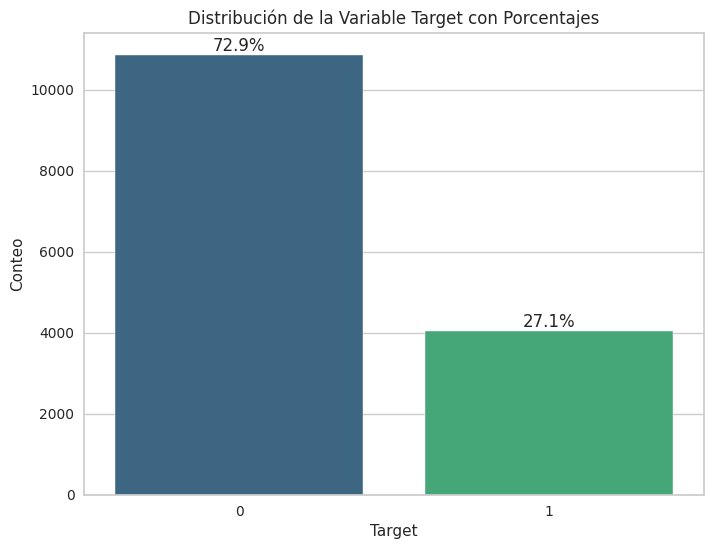

In [ ]:
# Analizo la distribucion de las clases de target correspondientes a Epitopo y No Epitopo
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=df_eda, hue='target', legend=False, palette='viridis')
plt.title('Distribución de la Variable Target con Porcentajes')
plt.xlabel('Target')
plt.ylabel('Conteo')

total = len(df_eda['target'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

This bar plot shows a moderate imbalance between Epitopes (27%) and Non Epitopoes (73%).

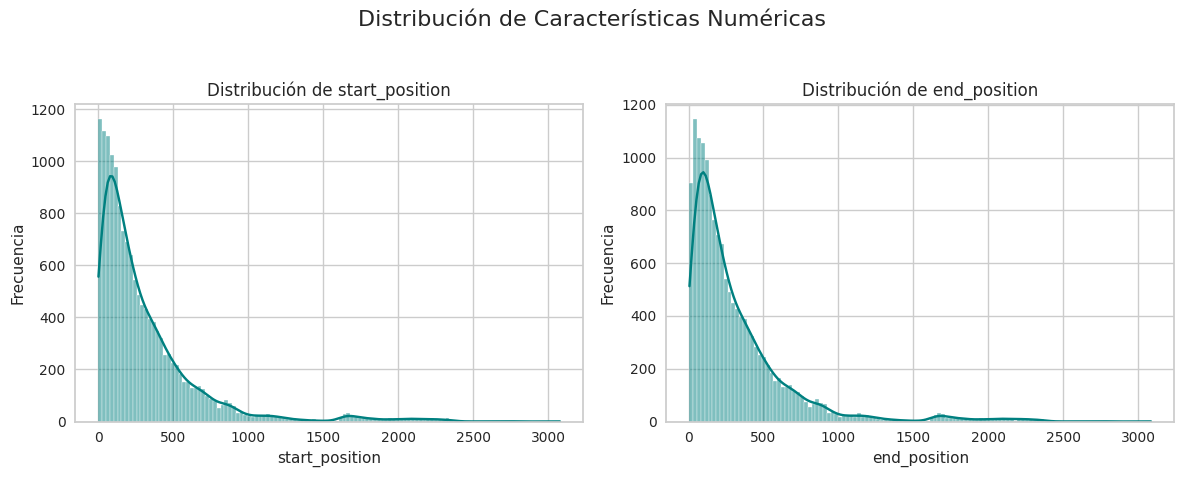

In [ ]:
plot_numerical_distributions(df_eda, ['start_position','end_position'])

Most of the peptides are found in an initial position that goes from 0 to 500.

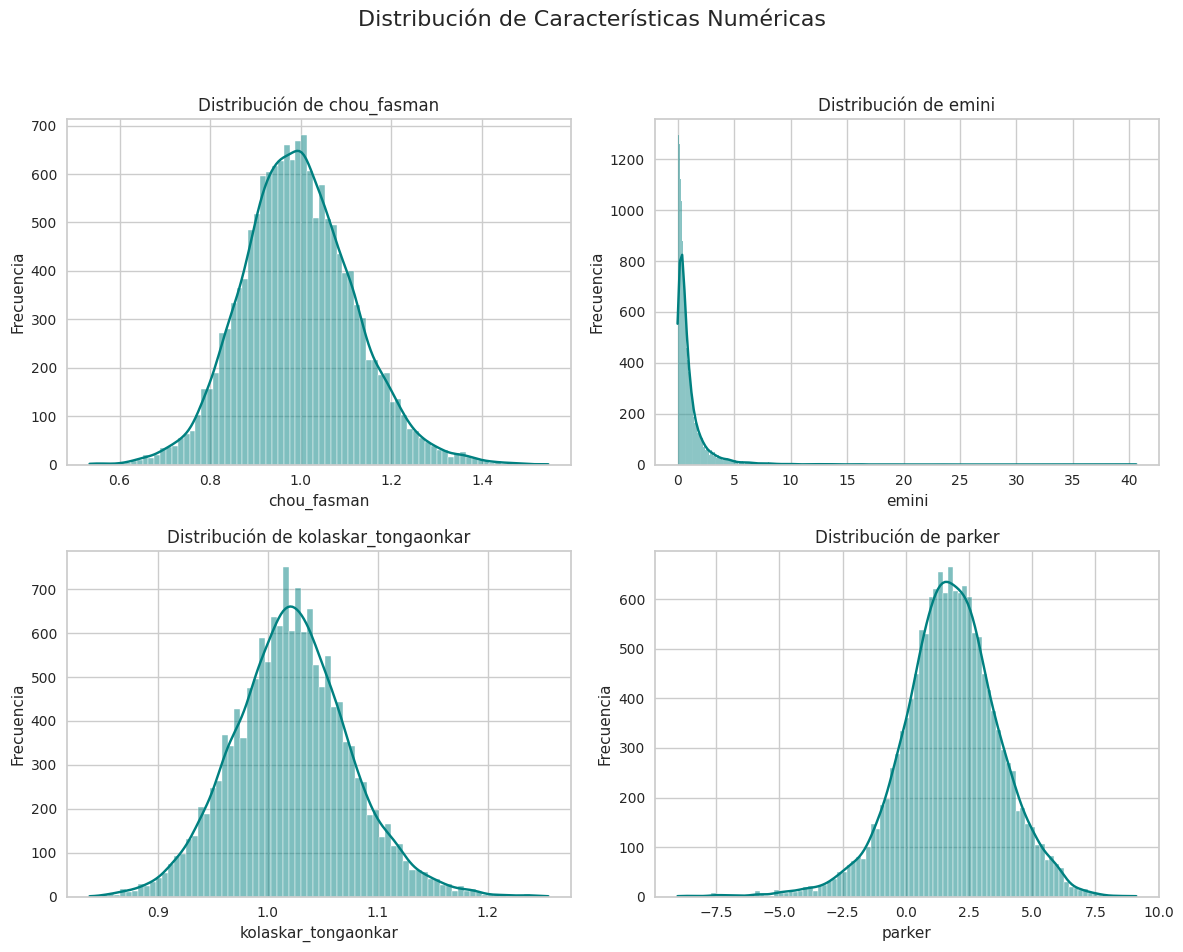

In [ ]:
plot_numerical_distributions(df_eda, ['chou_fasman', 'emini',	'kolaskar_tongaonkar', 'parker'])

The `chou_fasman`, `parker`, and `kolaskar_tongaonkar` features exhibit approximately normal distributions, centered around well-defined mean values. In contrast, the emini feature shows a pronounced peak between values 0 and 3, where the majority of observations are concentrated, along with a long right-tailed distribution extending up to values close to 40. This long tail suggests the presence of highly surface-accessible regions, which may correspond to potential epitope candidates.

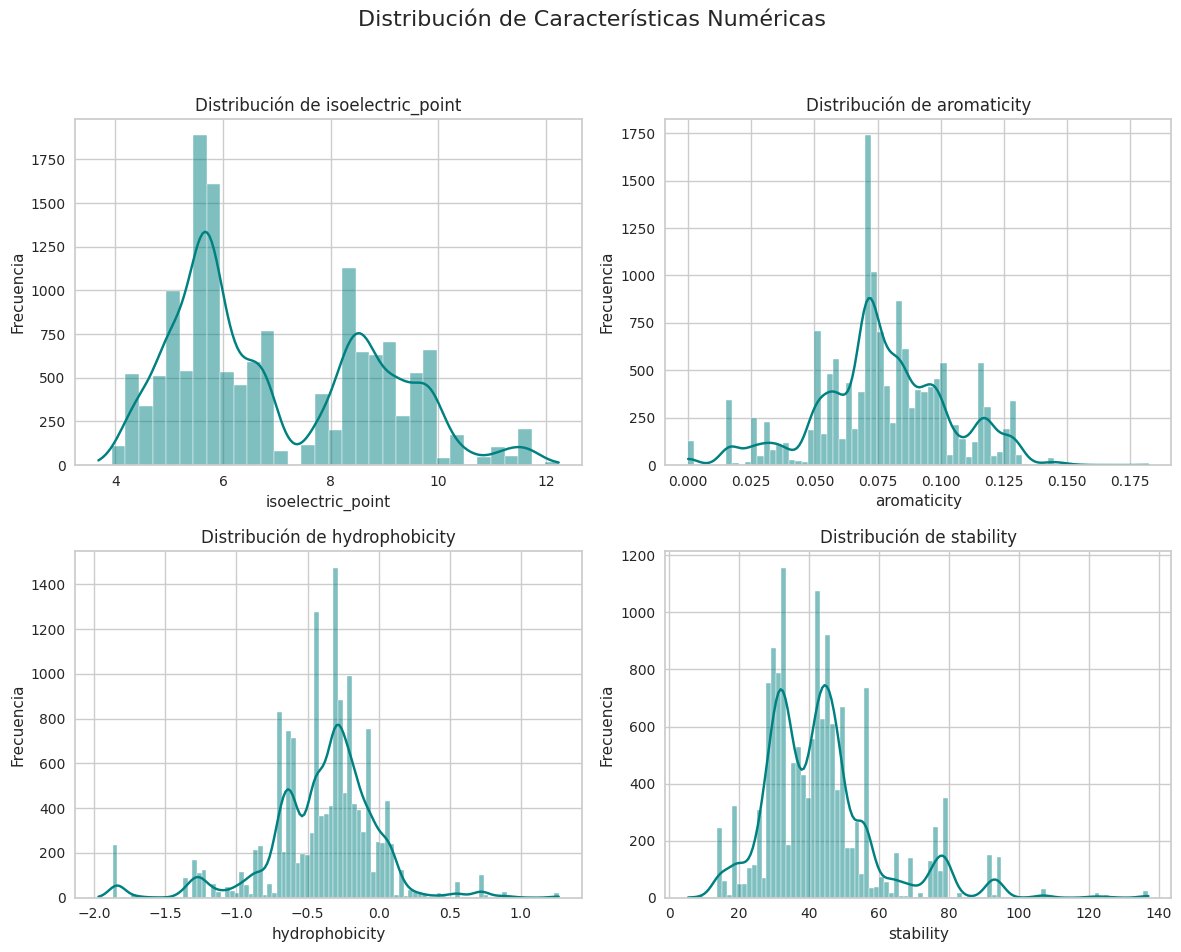

In [ ]:
plot_numerical_distributions(df_eda, ['isoelectric_point', 'aromaticity',	'hydrophobicity',	'stability'])

The `isoelectric_point` feature displays a multimodal distribution, characterized by several well-defined peaks. In contrast, `aromaticity` exhibits an asymmetric distribution, with a primary peak around 0.075 and additional secondary peaks on both sides, indicating variability in aromatic amino acid content. The `hydrophobicity` feature is predominantly distributed over negative values, showing an overall asymmetric shape, which suggests a predominance of hydrophilic regions. Finally, `stability` presents an asymmetric camel-shaped distribution, with higher density at lower values and a long tail extending toward higher values.

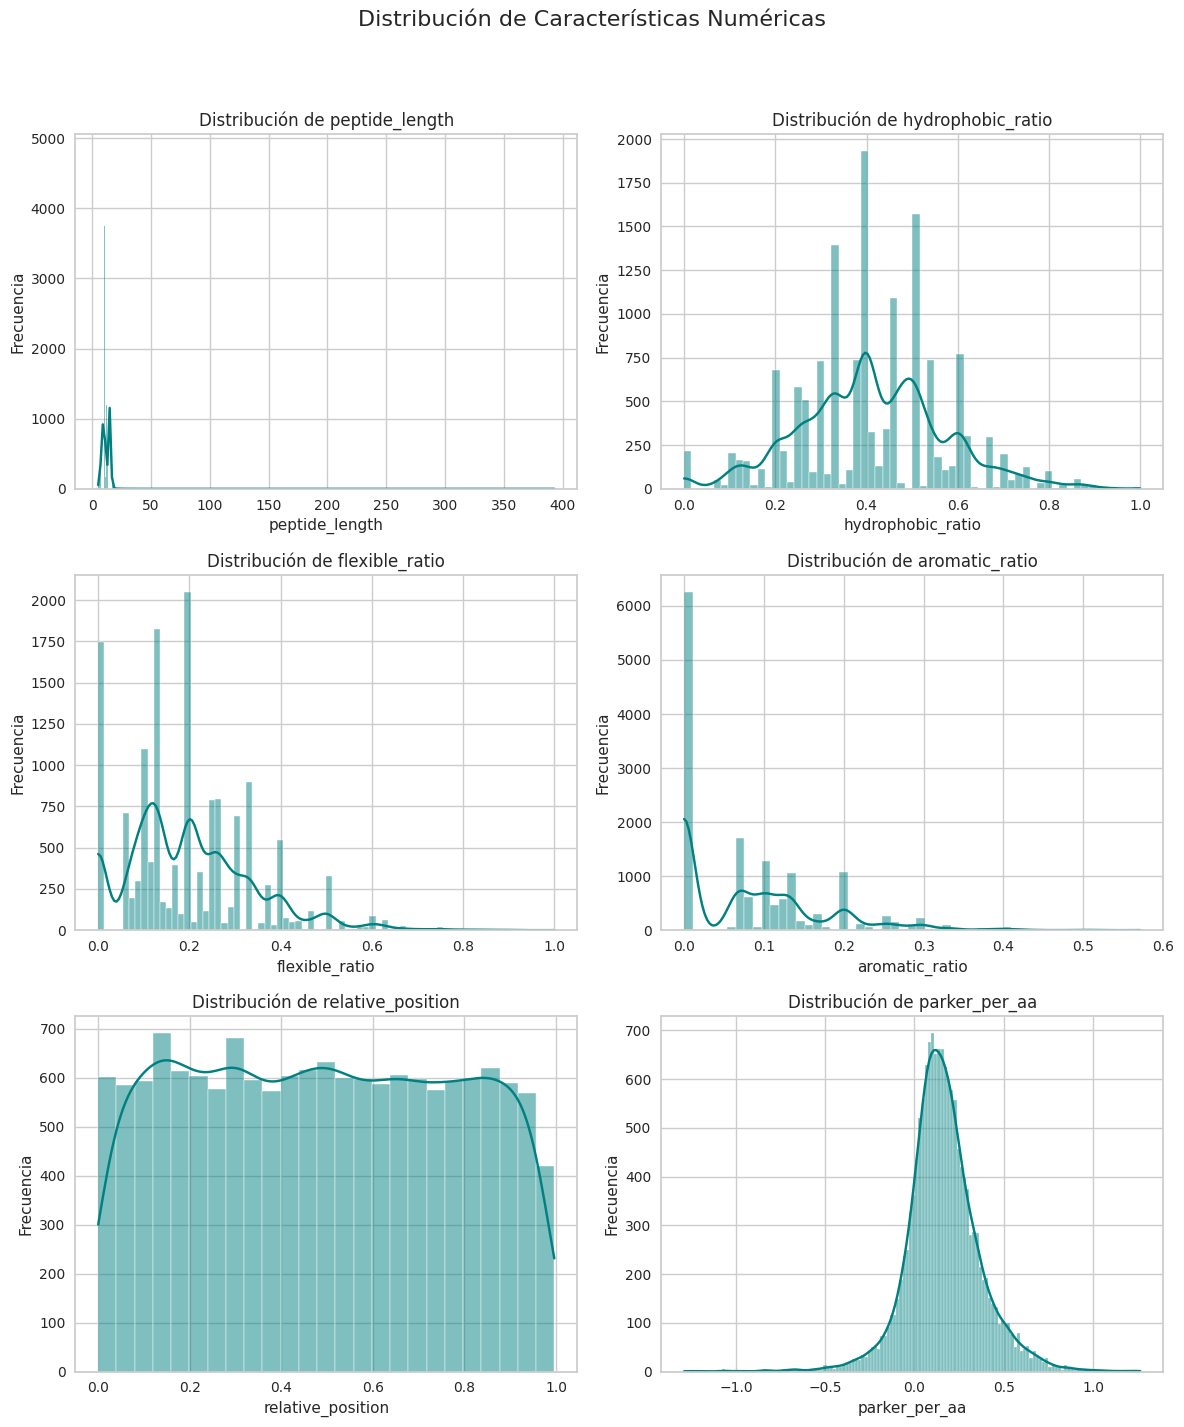

In [ ]:
plot_numerical_distributions(df_eda, ['peptide_length',	'hydrophobic_ratio',	'flexible_ratio',	'aromatic_ratio',	'relative_position',	'parker_per_aa'])

The `peptide_length` feature shows a distribution strongly concentrated around lower values, with a long tail extending toward higher values. The `hydrophobic_ratio` feature exhibits an approximately unimodal distribution, centered around intermediate values (≈0.4–0.5). In the case of `flexible_ratio`, the distribution is asymmetric, with a higher density at lower values.

The `aromatic_ratio` feature displays a strong concentration near zero, followed by a gradual decrease toward higher values. The `relative_position` feature shows a fairly uniform distribution across the interval [0, 1], indicating that peptides are distributed along the entire length of the parent proteins. Finally, `parker_per_aa` presents a distribution close to normal, centered around zero.

## Duplicados & Outliers

In [ ]:
# Buscar datos duplicados
duplicates = find_and_display_duplicates(df_eda)

Se encontraron 20


In [ ]:
display(duplicates.head(20))

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,peptide_length,hydrophobic_ratio,flexible_ratio,aromatic_ratio,relative_position,parker_per_aa
768,P06821,MSLLTEVETPIRNEWGCRCNGSSDPLAIAANIIGILHLILWILDRL...,6,13,EVETPIRN,0.930,1.055,0.982,2.800,5.681824,0.092784,-0.207216,42.820619,1,8,0.375000,0.125000,0.000000,0.061856,0.350000
769,P06821,MSLLTEVETPIRNEWGCRCNGSSDPLAIAANIIGILHLILWILDRL...,6,13,EVETPIRN,0.930,1.055,0.982,2.800,5.681824,0.092784,-0.207216,42.820619,1,8,0.375000,0.125000,0.000000,0.061856,0.350000
1976,P18012,MEIQNTKPTQTLYTDISTKQTQSSSETQKSQNYQQIAAHIPLNVGK...,162,169,VTQVGITG,0.936,0.139,1.062,1.550,7.830627,0.016529,-0.440496,45.818182,0,8,0.375000,0.250000,0.000000,0.446281,0.193750
1977,P18012,MEIQNTKPTQTLYTDISTKQTQSSSETQKSQNYQQIAAHIPLNVGK...,162,169,VTQVGITG,0.936,0.139,1.062,1.550,7.830627,0.016529,-0.440496,45.818182,0,8,0.375000,0.250000,0.000000,0.446281,0.193750
7306,P9WNK7,MTEQQWNFAGIEAAASAIQGNVTSIHSLLDEGKQSLTKLAAAWGGS...,85,95,STEGNVTGMFA,1.012,0.462,0.961,2.555,4.478577,0.063158,-0.255789,36.353684,1,11,0.272727,0.272727,0.090909,0.894737,0.232273
7307,P9WNK7,MTEQQWNFAGIEAAASAIQGNVTSIHSLLDEGKQSLTKLAAAWGGS...,85,95,STEGNVTGMFA,1.012,0.462,0.961,2.555,4.478577,0.063158,-0.255789,36.353684,1,11,0.272727,0.272727,0.090909,0.894737,0.232273
7979,P87020,MNYLLFCLFFAFSVAAPVTVTRFVDASPTGYDWRADWVKGFPIDSS...,221,232,YYALDVYAYDVT,0.946,0.621,1.119,0.433,5.004089,0.127090,-0.398328,31.725753,1,12,0.750000,0.000000,0.333333,0.739130,0.036083
7980,P87020,MNYLLFCLFFAFSVAAPVTVTRFVDASPTGYDWRADWVKGFPIDSS...,221,232,YYALDVYAYDVT,0.946,0.621,1.119,0.433,5.004089,0.127090,-0.398328,31.725753,1,12,0.750000,0.000000,0.333333,0.739130,0.036083
13323,P17763,MNNQRKKTGRPSFNMLKRARNRVSTVSQLAKRFSKGLLSGQGPMKL...,586,594,FKLEKEVAE,0.732,1.217,1.022,1.644,8.702576,0.081368,-0.203184,33.844487,1,9,0.444444,0.000000,0.111111,0.172759,0.182667
13324,P17763,MNNQRKKTGRPSFNMLKRARNRVSTVSQLAKRFSKGLLSGQGPMKL...,586,594,FKLEKEVAE,0.732,1.217,1.022,1.644,8.702576,0.081368,-0.203184,33.844487,1,9,0.444444,0.000000,0.111111,0.172759,0.182667


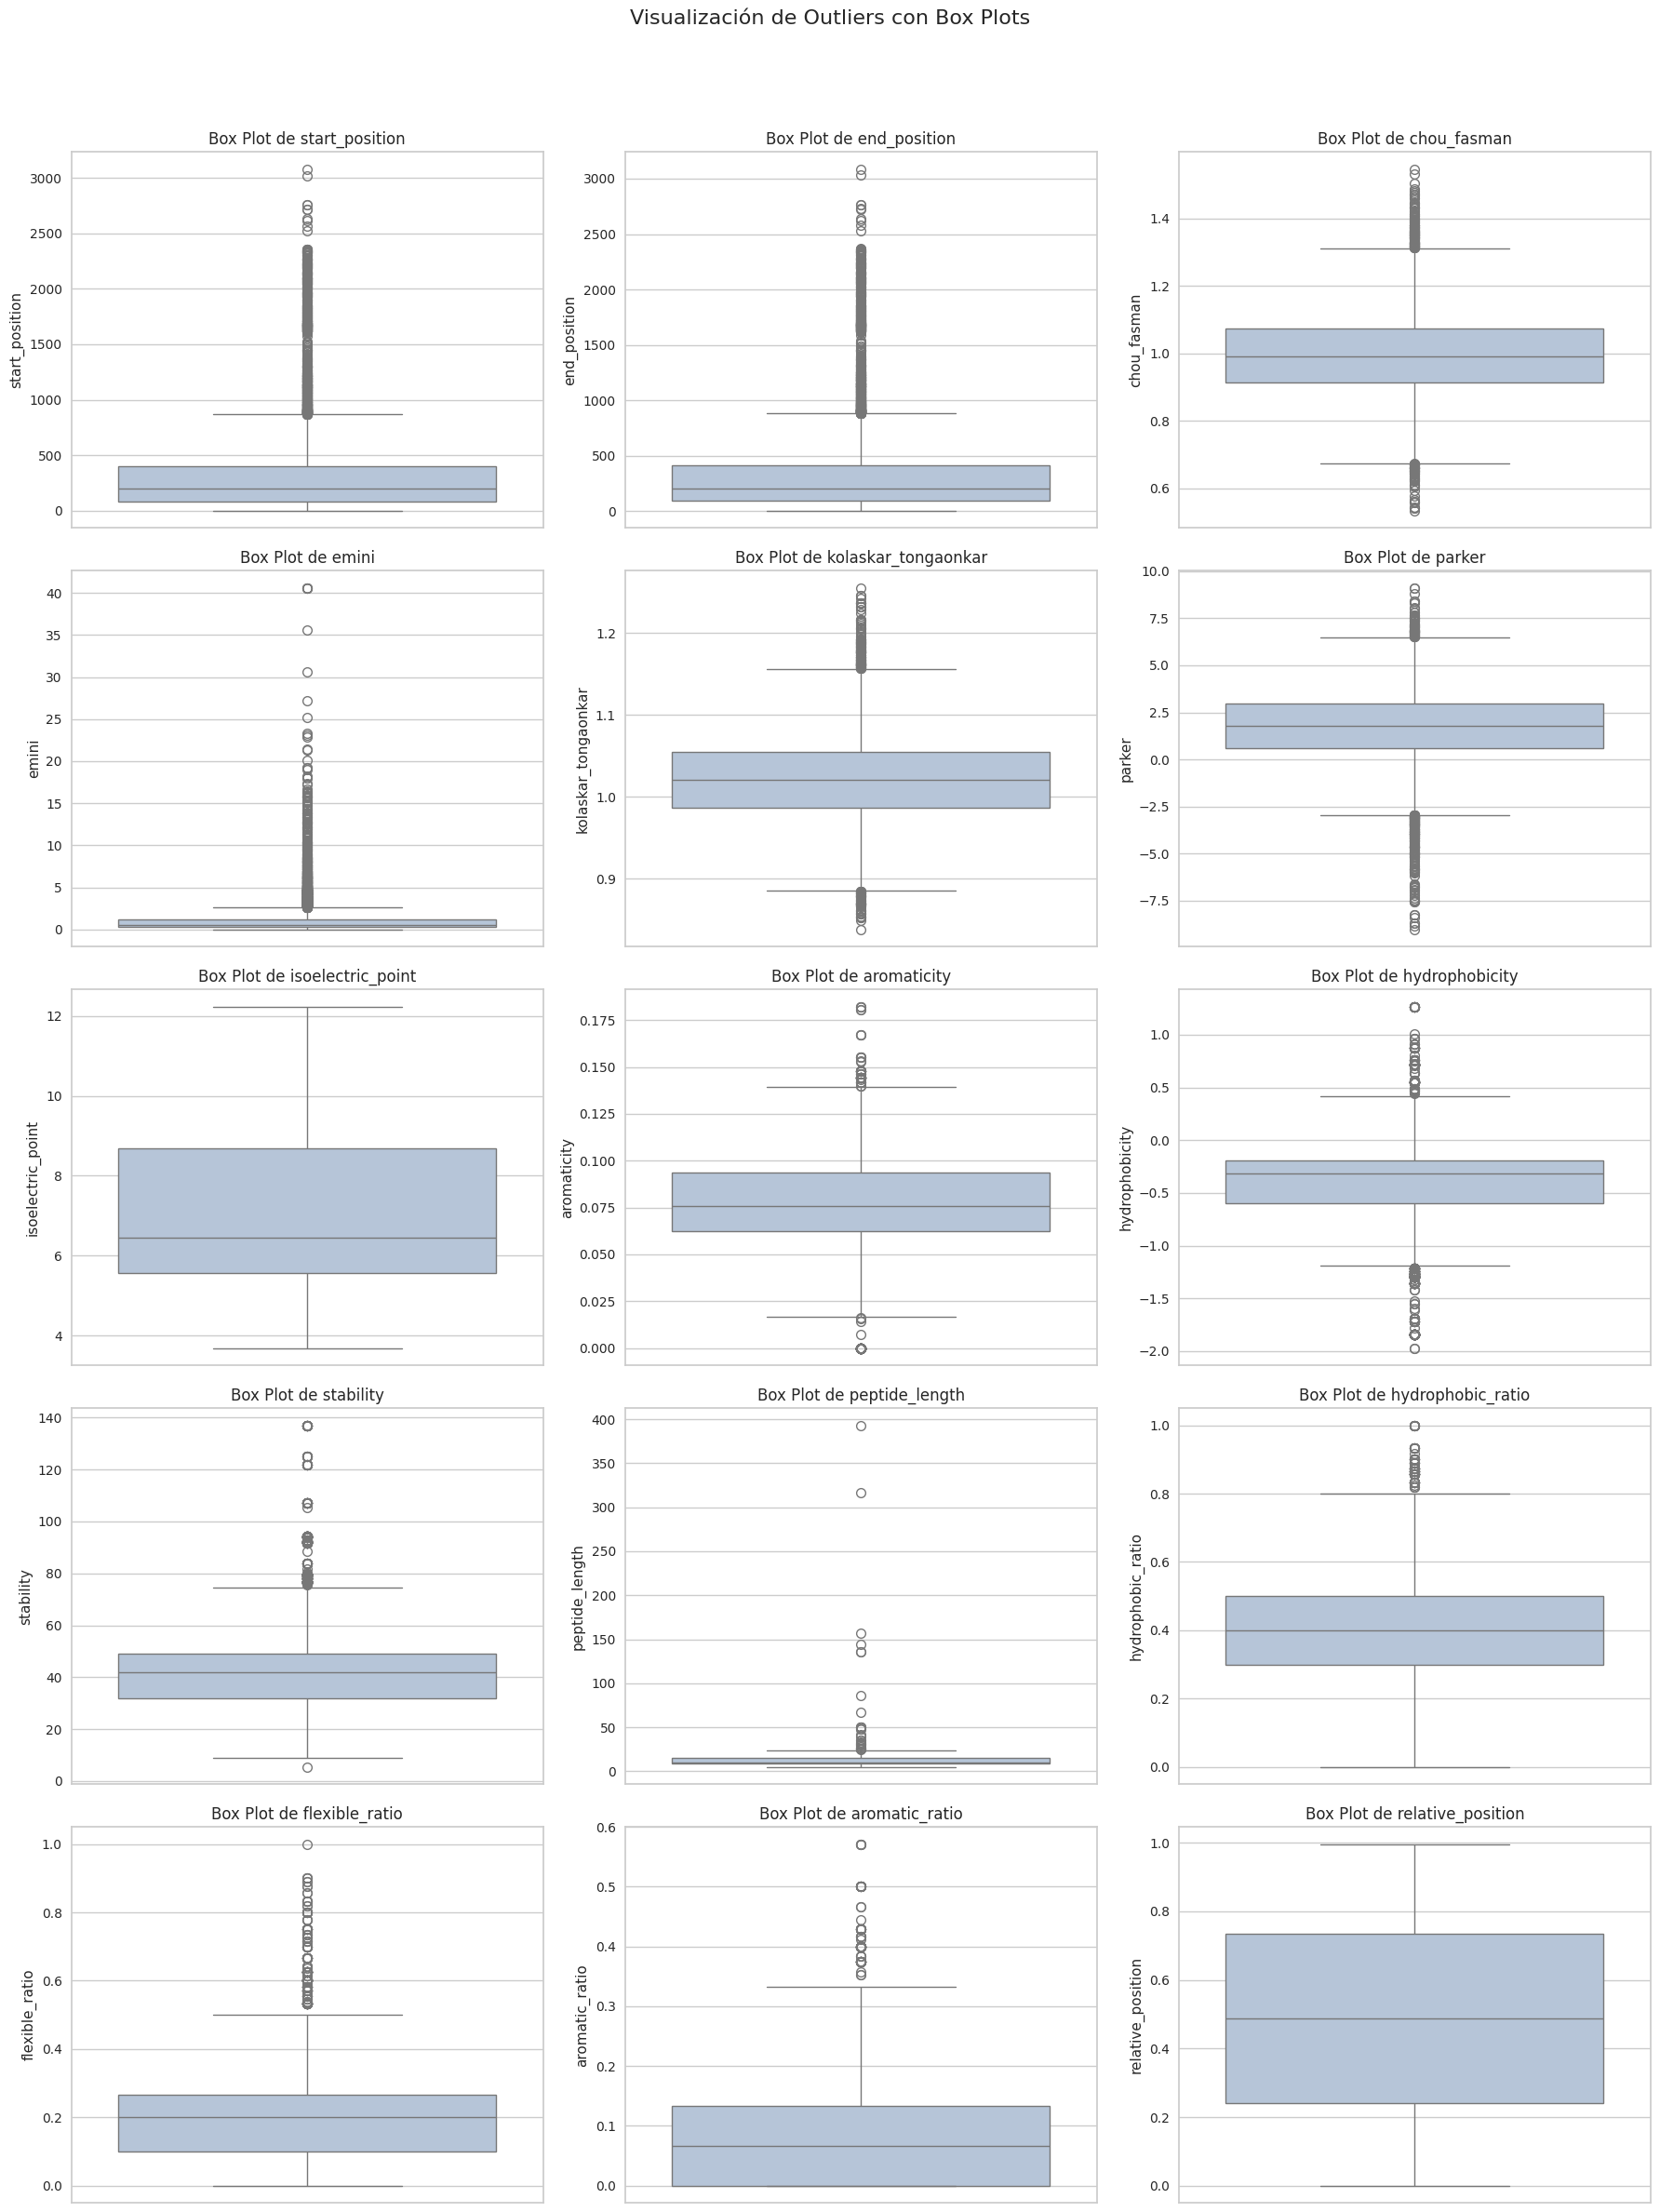

In [ ]:
# Boxplots para la identificacion de posibles outliers en las features
plot_outliers_boxplot(df_eda, numerical_cols)

Based on the distribution plots used to identify potential outliers, specific criteria were established for each variable according to its biological meaning and data-generating process.

In the case of `start_position` and `end_position`, although a large number of high values appear to be outliers, these values represent a normal and expected behavior of the data. Proteins may contain up to several thousand amino acids, and epitopes can naturally occur near the end or deep within a protein sequence. Therefore, no imputation or filtering was applied to these two variables.

Similarly, for the variables `emini`, `chou_fasman`, `kolaskar_tongaonkar`, and `parker`, no imputation was performed. Although some values deviate substantially from the central tendency, these extreme values are biologically logic given the nature of the physicochemical scales. In particular, high emini values correspond to regions with increased surface accessibility, which may indicate highly exposed antigenic regions.

Emini, E. A., et al. (1985). Induction of hepatitis A virus-neutralizing antibody by a virus-specific synthetic peptide. Journal of Virology, 55(3), 836–839. https://doi.org/10.1128/JVI.55.3.836-839.1985

In contrast, the `peptide_length` variable does exhibit biologically implausible extreme values. B-cell epitopes are typically expected to range between 8 and 25 amino acids in length. Consequently, peptide sequences were filtered to retain only those with lengths between 6 and 27 amino acids, this slightly relaxed threshold is just to avoid excessive strictness. This decision is supported by the literature, which reports that approximately 80% of B-cell epitopes are longer than 8 amino acids, while shorter sequences can still occur.

Ras-Carmona, A., et al. (2022). Prediction of B cell epitopes in proteins using a novel sequence similarity-based method. Scientific Reports, 12, 13739. https://doi.org/10.1038/s41598-022-18021-1

For the remaining variables, a situation analogous to that of emini, chou_fasman, and related features was observed. Although these variables present extreme values, they are consistent with biologically meaningful variability. As a result, rather than removing or imputing these observations, scaling and transformation techniques were preferred to stabilize their distributions and ensure appropriate behavior during model training.

## True Correlation Matrix

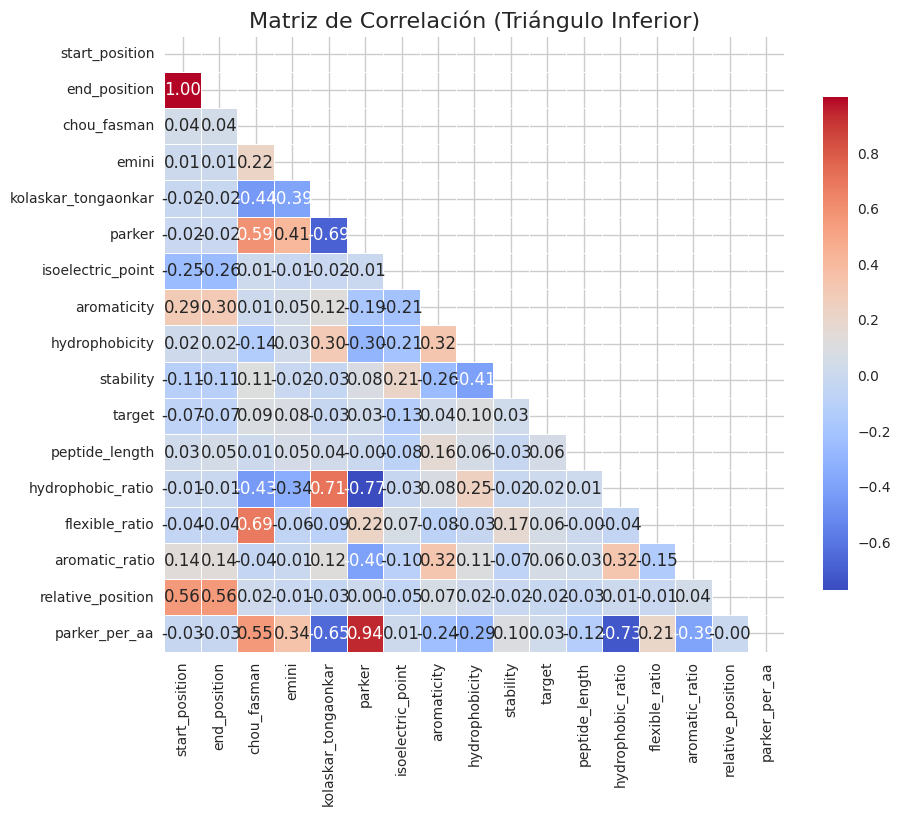

In [ ]:
plot_corr_matrix(df_eda)

Strong Positive Correlations:

- parker – parker_per_aa (0.94)

- chou_fasman – flexible_ratio (0.69)


- chou_fasman – hydrophobic_ratio (0.43)

- relative_position – start_position / end_position (0.56)

- hydrophobic_ratio – flexible_ratio (0.73)

Strong Negative Correlations:

- kolaskar_tongaonkar – parker (−0.69)

- hydrophobic_ratio – parker (−0.77)

- parker – aromatic_ratio (−0.75)

- parker_per_aa – kolaskar_tongaonkar (−0.65)

## Data Cleaning

In [ ]:
df_clean = df_eda.copy()

In [ ]:
# Elimino duplicados
df_clean.drop_duplicates(inplace=True)

In [ ]:
find_and_display_duplicates(df_clean)

No se encontraron filas duplicadas.


,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,peptide_length,hydrophobic_ratio,flexible_ratio,aromatic_ratio,relative_position,parker_per_aa


In [ ]:
# Filtro para dejar solamente los peptidos con longitud de 6 a 27 aa
df_clean = df_clean[df_clean["peptide_length"].between(6, 27)]

# Hierarchical Clustering

A Hierarchical Clustering will be performed to analyze how data assembles naturally. From the results obtained, a new categorical feature will be created and incorporated in for the following classification models.


In [ ]:
# Defino un nuevo df para trabajar con el clusterizado jerarquico
df_hier_clust = df_clean.copy()
df_hier_clust.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,peptide_length,hydrophobic_ratio,flexible_ratio,aromatic_ratio,relative_position,parker_per_aa
68,A1JIP3,MAAKDVKFGNDARIKMLRGVNILADAVKVTLGPKGRNVVLDKSFGS...,321,326,KRVVIN,0.832,0.645,1.083,0.250,4.868713,0.027273,0.008909,32.973091,1,6,0.500000,0.000000,0.000000,0.583636,0.041667
69,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,268,273,QIINTY,0.930,0.757,1.027,0.050,5.810364,0.103275,-0.143829,40.273300,1,6,0.500000,0.000000,0.166667,0.675063,0.008333
70,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,385,390,VFTVAS,0.775,0.228,1.140,-0.467,5.810364,0.103275,-0.143829,40.273300,1,6,0.666667,0.166667,0.166667,0.969773,-0.077833
71,B8Y9S9,MLGGPGPGLLLLLAVLSLGTAVPSAGASKSRRQAQQIVQPQSPLTV...,1695,1700,PGSEYT,1.225,1.573,0.978,4.233,5.496521,0.077084,-0.523419,40.989828,1,6,0.333333,0.500000,0.166667,0.710096,0.705500
72,B9T8T0,MKPGGNTIVIWMYAVATWLCFGSTSGWSFTLEDNNIFPKQYPIINF...,297,302,PPSSQF,1.247,1.627,1.043,2.333,6.342712,0.100694,-0.152604,39.030556,1,6,0.500000,0.666667,0.166667,0.515625,0.388833


In [ ]:
# Elimino las features
df_hier_clust = df_hier_clust.drop(['start_position', 'end_position', 'parent_protein_id', 'protein_seq', 'peptide_seq'], axis=1)

In [ ]:
X_hier_clust = df_hier_clust.drop('target', axis=1)

scaler = StandardScaler()
X_hier_clust_scaled = scaler.fit_transform(X_hier_clust)


## Metrics Selection

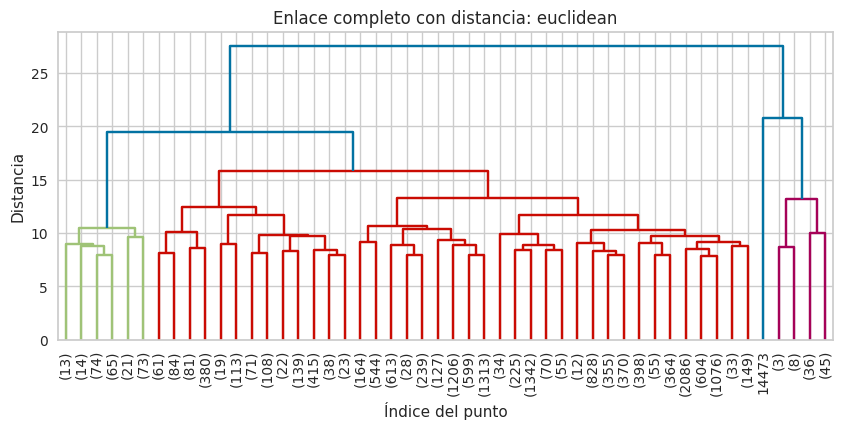

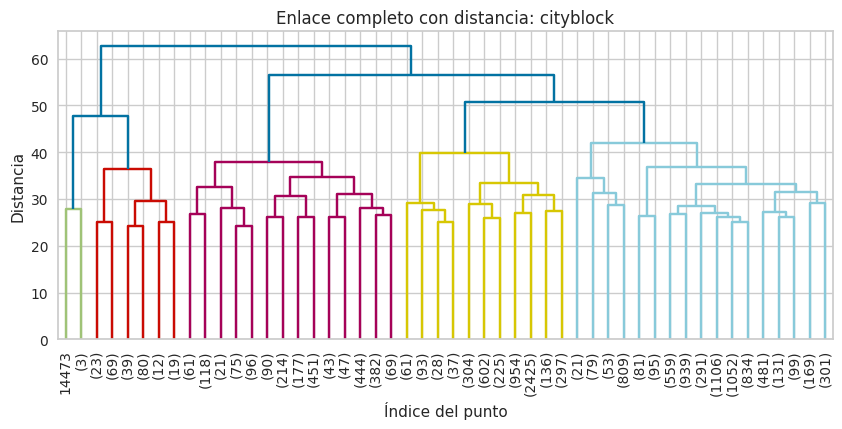

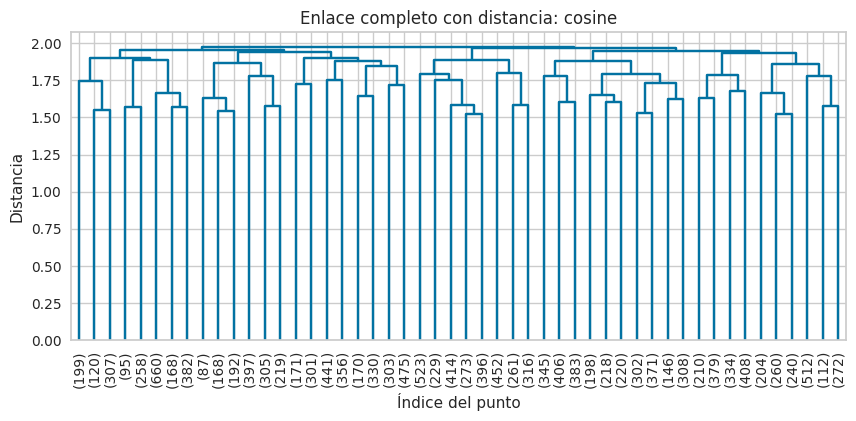

In [ ]:
metrics = ['euclidean', 'cityblock', 'cosine']

for metric in metrics:
    Z = linkage(X_hier_clust_scaled, method='complete', metric=metric)
    plt.figure(figsize=(10, 4))
    dendrogram(Z,
        truncate_mode="lastp",
        p=50,
        leaf_rotation=90,
        leaf_font_size=10
    )

    plt.title(f"Enlace completo con distancia: {metric}")
    plt.xlabel("Índice del punto")
    plt.ylabel("Distancia")
    plt.show()


Based on the dendrograms obtained from the different clustering configurations, Euclidean and cityblock (Manhattan) distances were selected, as they exhibit much longer global branches compared to those obtained using cosine distance. This behavior indicates a clearer hierarchical structure and better separation between clusters, whereas cosine distance produces shorter branches that suggest weaker global dissimilarities among observations.

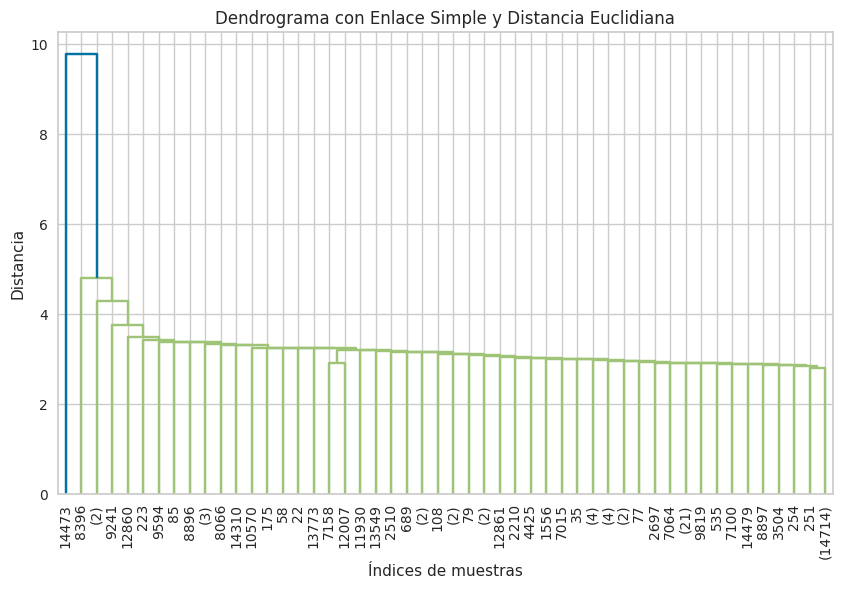

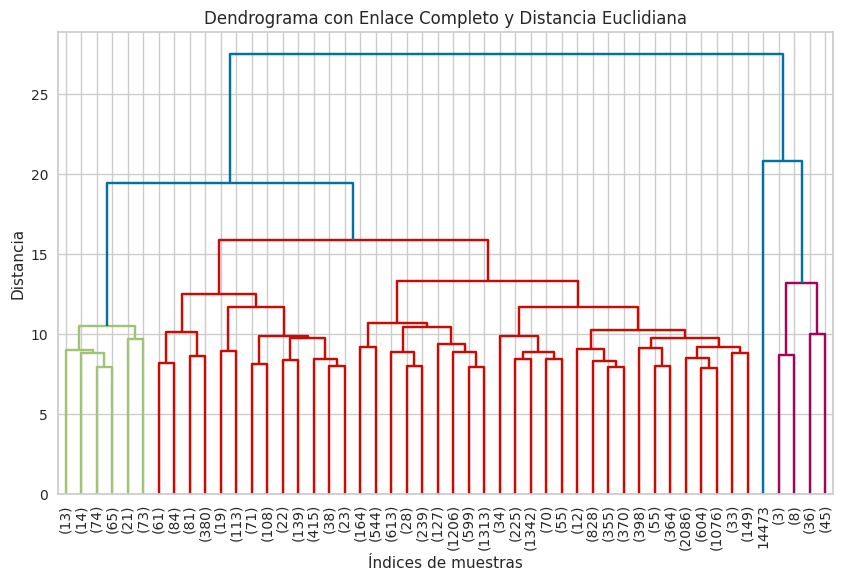

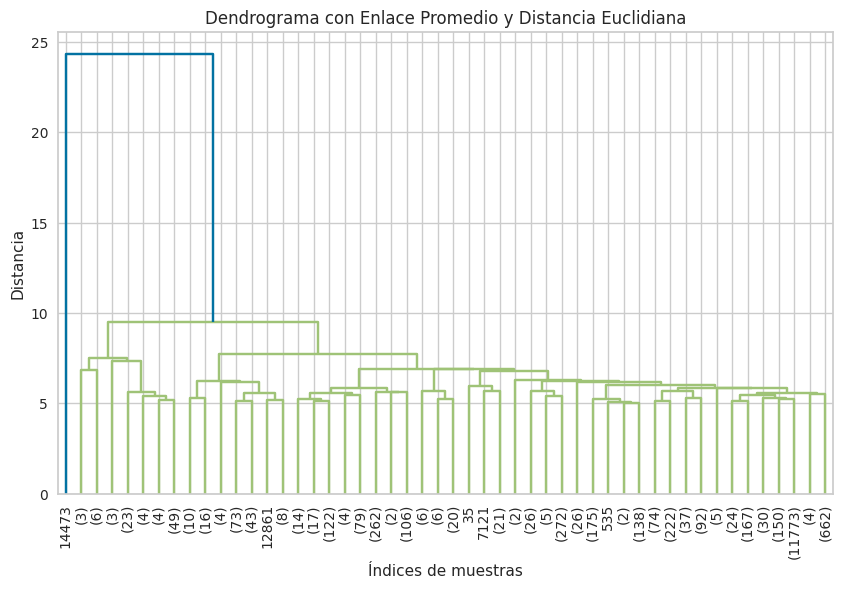

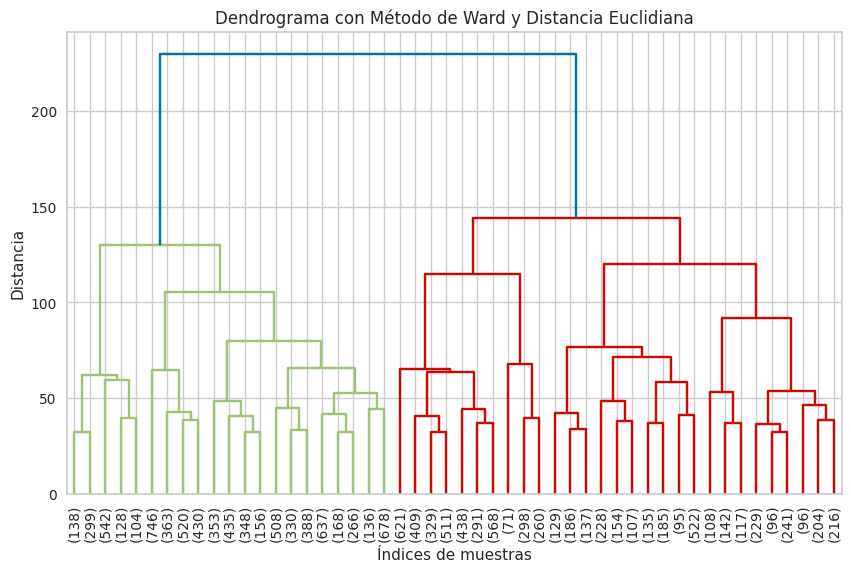

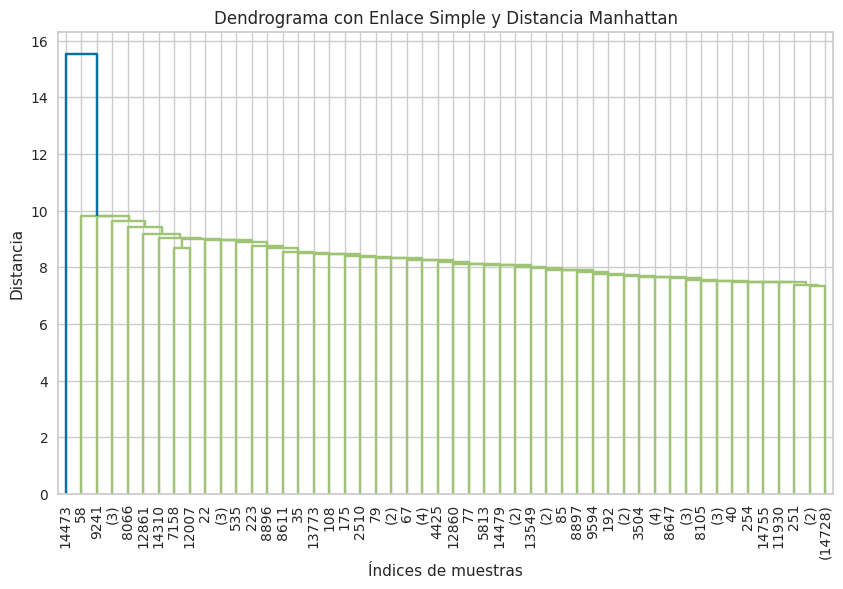

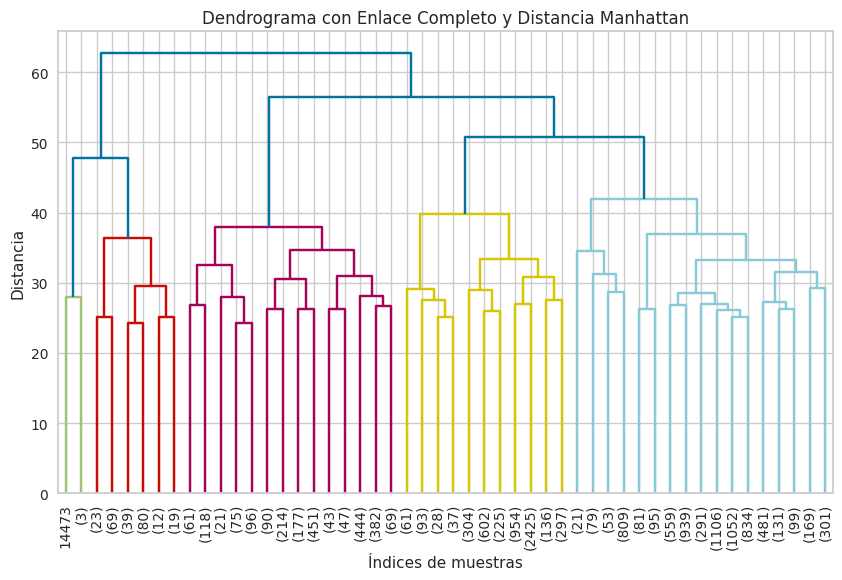

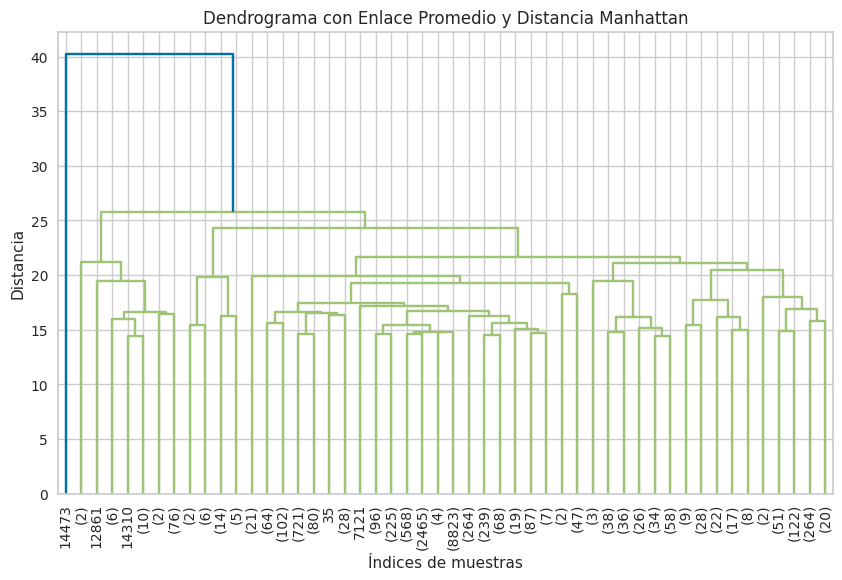

In [ ]:
methods = ['single', 'complete', 'average', 'ward']
distances = ['euclidean', 'cityblock']
method_names = ['Enlace Simple', 'Enlace Completo', 'Enlace Promedio', 'Método de Ward']
distance_names = ['Distancia Euclidiana', 'Distancia Manhattan']

for distance, distance_name in zip(distances, distance_names):
    for method, method_name in zip(methods, method_names):
        # Ward solo con Euclidiana
        if method == 'ward' and distance != 'euclidean':
            continue

        Z = linkage(X_hier_clust_scaled, method=method, metric=distance)

        plt.figure(figsize=(10, 6))
        dendrogram(Z, truncate_mode="lastp", p=50, leaf_rotation=90, leaf_font_size=10)
        plt.title(f'Dendrograma con {method_name} y {distance_name}')
        plt.xlabel('Índices de muestras')
        plt.ylabel('Distancia')
        plt.show()

I consider that the most reliable dendograms are the ones with Ward linkage Method and Complete linkage Method combined with Euclidean Distance because of their larger global branches and their shorter leaf branches.


## **Final HC Model**

The final hierarchical clustering model will be selected based on the epitope ratios within each cluster across the different configurations.

The dendrogram cut used to determine the number of clusters was established through visual inspection, prioritizing cuts that resulted in a more organic and interpretable cluster structure.

### Ward - Euclidean

For the Ward–Euclidean model, a cut producing six clusters was selected as the most appropriate. This choice avoids reducing the clustering to only two groups, which would effectively force a binary separation between epitope and non-epitope classes and undermine the exploratory nature of the unsupervised analysis. With six clusters, the dendrogram displays branches of substantial length, indicating meaningful separation between groups, while the sub-branches generated beyond this cut are noticeably shorter, suggesting diminishing returns in further subdivision.

In [ ]:
# Genero un df con la nueva feature de clusterizado con sus clases
hc = AgglomerativeClustering(
    n_clusters=6,
    linkage="ward"
)

df_hier_clust["hc_cluster"] = hc.fit_predict(X_hier_clust_scaled)

In [ ]:
# Calculo del ratio de epitopos en cada cluster
cluster_epitope_ratio = (
    df_hier_clust.groupby("hc_cluster")["target"]
    .mean()
    .rename("epitope_ratio")
)

print(cluster_epitope_ratio)


hc_cluster
0    0.267255
1    0.308307
2    0.189096
3    0.166804
4    0.365660
5    0.296495
Name: epitope_ratio, dtype: float64


In this case the results show two clusters presenting a 30% of Epitopes (1 and 5) and one cluster with 36% of Epitopes (cluster 4).

### Complete - Euclidean


In [ ]:
# Genero un df con la nueva feature de clusterizado con sus clases
hc_complete = AgglomerativeClustering(
    n_clusters=4,
    linkage="complete"
)

df_hier_clust["hc_complete"] = hc_complete.fit_predict(X_hier_clust_scaled)

In [ ]:
# Calculo del ratio de epitopos en cada cluster
cluster_epitope_ratio_complete = (
    df_hier_clust.groupby("hc_complete")["target"]
    .mean()
    .rename("epitope_ratio_complete")
)

print(cluster_epitope_ratio_complete)

hc_complete
0    0.267257
1    0.391304
2    1.000000
3    0.207692
Name: epitope_ratio_complete, dtype: float64


In the Complete linkage with Euclidean distance configuration, Cluster 1 exhibits a relatively high epitope proportion, reaching approximately 40% of epitope instances. In contrast, Cluster 2, which contains a single observation, corresponds to an epitope. This case is considered particularly relevant for further analysis, as it may represent either an outlier or a peptide with distinctive properties that could provide valuable insights aligned with the objectives of this study.

## Clusters Profiles

The Complete linkage method with Euclidean distance was chosen as the final hierarchical clustering configuration, as it exhibits a notably high proportion of epitopes within Cluster 1. This elevated epitope concentration makes the clustering particularly informative and relevant for the objectives of this study, motivating its selection over alternative configurations.

In [ ]:
# Analizo las medias de las features para cada clase generada
cluster_profiles = df_hier_clust.groupby("hc_complete").mean()
cluster_profiles


,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,peptide_length,hydrophobic_ratio,flexible_ratio,aromatic_ratio,relative_position,parker_per_aa,hc_cluster,hc_complete_cityblock
hc_complete,,,,,,,,,,,,,,,,,
0,0.997488,0.998204,1.020489,1.823464,7.013648,0.076715,-0.400095,43.281490,0.267257,11.622862,0.405988,0.201153,0.078504,0.489029,0.170409,1.775531,0.690161
1,1.062967,13.886457,0.952304,4.427707,6.911995,0.089438,-0.236939,43.499770,0.391304,13.760870,0.233319,0.140583,0.078342,0.434114,0.344877,4.000000,2.717391
2,1.098000,40.605000,0.982000,2.669000,5.569763,0.116335,-0.061116,33.205116,1.000000,26.000000,0.346154,0.153846,0.192308,0.341833,0.102654,4.000000,4.000000
3,0.811592,0.218723,1.122108,-3.392008,7.244711,0.092130,-0.164059,46.613384,0.207692,8.569231,0.760868,0.127816,0.223190,0.500660,-0.417043,2.861538,0.992308


The features whose mean values most clearly distinguish class 1 from the remaining classes are `parker` and `hydrophobicity`.

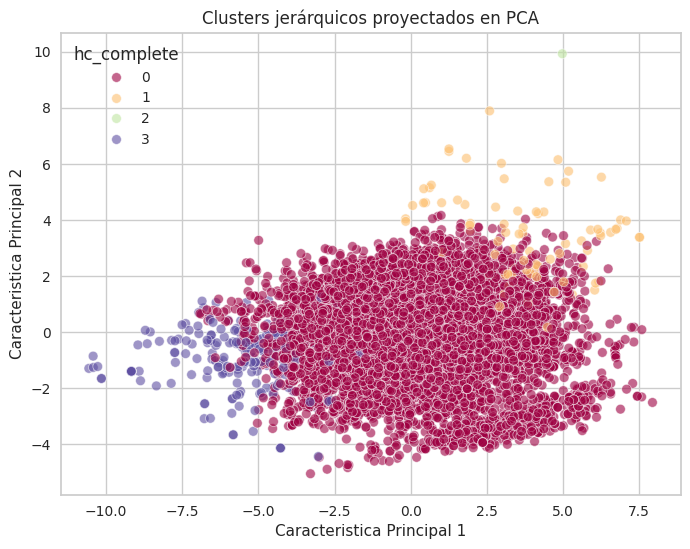

In [ ]:
# Genero un PCA para reducir dimensionalidad y ver como se distribuyen las clases
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_hier_clust_scaled)

df_hier_clust["Caracteristica Principal 1"] = X_pca[:, 0]
df_hier_clust["Caracteristica Principal 2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_hier_clust, x="Caracteristica Principal 1", y="Caracteristica Principal 2", hue="hc_complete", palette="Spectral", alpha=0.6)
plt.title("Clusters jerárquicos proyectados en PCA")
plt.show()

Based on the projection onto the first two principal components, Cluster 0 contains the largest proportion of observations. Clusters 1 and 3 share some spatial overlap with Cluster 0 but occupy more distant regions of the feature space, with Cluster 3 taking lower values along the x-axis and Cluster 1 exhibiting higher values along the y-axis. Cluster 2, which consists of a single observation, is located in the upper corner of the plot, clearly separated from the remaining clusters.

Nevertheless, it is of interest to examine the data in a three-dimensional representation to assess whether the clusters exhibit improved separation when additional principal components are considered.

In [ ]:
# Genero un PCA con 3 componentes para analizar tridimensionalmente la distribucion de las clases
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_hier_clust_scaled)

# Obtengo las etiquetas de 'hc_complete' de df_hier_clust
cluster_labels = df_hier_clust["hc_complete"]

# Creo un df temporal para facilitar el ordenamiento
df_plot = pd.DataFrame({'PC1': X_pca_3d[:, 0], 'PC2': X_pca_3d[:, 1], 'PC3': X_pca_3d[:, 2], 'Cluster': cluster_labels})

# Ordeno por el número de cluster para que la leyenda sea 0, 1, 2...
df_plot = df_plot.sort_values('Cluster')

# Convertir a string para que Plotly use una escala discreta (colores distintos)
df_plot['Cluster'] = df_plot['Cluster'].astype(str)

# Graficar
fig = px.scatter_3d(df_plot, x='PC1',  y='PC2',  z='PC3', color='Cluster',
    title='PCA 3D - Clusters Ordenados', color_discrete_sequence=px.colors.qualitative.Dark2)

# Ajustes de tamaño y puntos
fig.update_traces(marker=dict(size=3, line=dict(width=0)))
fig.update_layout(width=1000,  height=800, margin=dict(l=0, r=0, b=0, t=50),
    legend=dict(title="Número de Cluster", itemsizing='constant'))

fig.show()

When analyzed in a three-dimensional projection, Cluster 2 appears to exhibit a clearer separation from Cluster 0. Although Cluster 3 shares part of the feature space with Cluster 0, it achieves a more distinct separation along the x-axis (Principal Component 1), particularly in the range from approximately −5 to −10.

# Classiffier

In this section, a binary classification model is developed to distinguish between epitopes and non-epitopes. The analysis focuses primarily on the F1-score and recall metrics, as, in a biological context, false positives can be filtered out through experimental validation, whereas false negatives correspond to the loss of potentially relevant epitopes.

In [ ]:
# Genero un df para la seccion de clasificacion
df_clf = df_clean.copy()

In [ ]:
# Agrego al df la columna generada en el clusterizado con las 4 clases
df_clf = df_clf.drop(['parent_protein_id', 'protein_seq', 'peptide_seq'], axis=1)
df_clf['hc_complete'] = df_hier_clust['hc_complete']

In [ ]:
# Divido la columna hc_complete en 4 para que queden codificadas de manera binaria
# Crea las 4 columnas automáticamente
df_dummies = pd.get_dummies(df_clf['hc_complete'], prefix='cluster')

# Unir al dataframe
df_clf = pd.concat([df_clf, df_dummies], axis=1)
df_clf = df_clf.drop('hc_complete', axis=1)
df_clf.head()

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,...,peptide_length,hydrophobic_ratio,flexible_ratio,aromatic_ratio,relative_position,parker_per_aa,cluster_0,cluster_1,cluster_2,cluster_3
68,321,326,0.832,0.645,1.083,0.250,4.868713,0.027273,0.008909,32.973091,...,6,0.500000,0.000000,0.000000,0.583636,0.041667,True,False,False,False
69,268,273,0.930,0.757,1.027,0.050,5.810364,0.103275,-0.143829,40.273300,...,6,0.500000,0.000000,0.166667,0.675063,0.008333,True,False,False,False
70,385,390,0.775,0.228,1.140,-0.467,5.810364,0.103275,-0.143829,40.273300,...,6,0.666667,0.166667,0.166667,0.969773,-0.077833,True,False,False,False
71,1695,1700,1.225,1.573,0.978,4.233,5.496521,0.077084,-0.523419,40.989828,...,6,0.333333,0.500000,0.166667,0.710096,0.705500,True,False,False,False
72,297,302,1.247,1.627,1.043,2.333,6.342712,0.100694,-0.152604,39.030556,...,6,0.500000,0.666667,0.166667,0.515625,0.388833,True,False,False,False


In [ ]:
# Diccionario para almacenar resultados de rendimiento y tiempos
model_results = {}

In [ ]:
# Definición de Features (X) y Target (y)
X = df_clf.drop('target', axis=1)
y = df_clf['target']

# División en Train y Test (estratificada para mantener la proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Escalar las features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Forma de X_train escalado:", X_train_scaled.shape)
print("Forma de X_test escalado:", X_test_scaled.shape)

Forma de X_train escalado: (11097, 20)
Forma de X_test escalado: (3699, 20)


## Logistic Regression

A Logistic Regression is performed as a base model to obtain a preliminar information.

In [ ]:
# Regresión Logística

print("--- Entrenando Regresión Logística ---")
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

start_time = time.time()
log_reg.fit(X_train_scaled, y_train)
end_time = time.time()
train_time_dt = end_time - start_time

y_pred_log_reg = log_reg.predict(X_test_scaled)

print(f"Tiempo de entrenamiento (Logistic Regression): {train_time_dt:.4f} segundos")
print("\n\n\nReporte de clasificación (Logistic Regression - Test):")
print(classification_report(y_test, y_pred_log_reg))

# Obtener el classification report para calcular el F1-score
report_log_reg = classification_report(y_test, y_pred_log_reg, output_dict=True)
f1_score_log_reg_weighted = report_log_reg['weighted avg']['f1-score']

# Guardamos los resultados y tiempo de entrenamiento en nuestro diccionario
model_results['Logistic Regression'] = {
    'Recall': recall_score(y_test, y_pred_log_reg, pos_label=1),
    'F1_Score_Weighted': f1_score_log_reg_weighted,
    'Train_Time_s': train_time_dt
}

--- Entrenando Regresión Logística ---
Tiempo de entrenamiento (Logistic Regression): 0.0721 segundos



Reporte de clasificación (Logistic Regression - Test):
              precision    recall  f1-score   support

           0       0.82      0.60      0.69      2711
           1       0.37      0.64      0.47       988

    accuracy                           0.61      3699
   macro avg       0.59      0.62      0.58      3699
weighted avg       0.70      0.61      0.63      3699



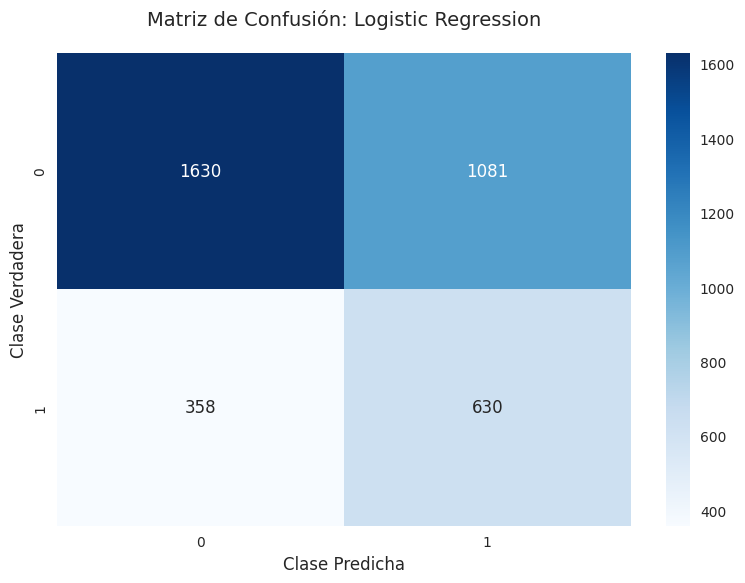

In [ ]:
# Genero la martriz de confusion
plot_confusion_matrix(y_test, y_pred_log_reg, log_reg.classes_, "Logistic Regression")

The Linear Regression model exhibits clear limitations when applied to the classification task for this particular dataset.

## Random Forest

In [ ]:
print("--- Entrenando Random Forest ---")
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced")

start_time = time.time()
rf_clf.fit(X_train_scaled, y_train)
end_time = time.time()
train_time_rf_clf = end_time - start_time

y_pred_rf_clf = rf_clf.predict(X_test_scaled)

print(f"Tiempo de entrenamiento (Random Forest): {train_time_rf_clf:.4f} segundos")
print("\n\n\nReporte de clasificación (Random Forest - Test):")
print(classification_report(y_test, y_pred_rf_clf))

# Obtener el classification report para calcular el F1-score
report_rf_clf = classification_report(y_test, y_pred_rf_clf, output_dict=True)
f1_score_rf_clf_weighted = report_rf_clf['weighted avg']['f1-score']

# Guardamos los resultados y tiempo de entrenamiento en nuestro diccionario
model_results['Random Forest'] = {
    'Recall': recall_score(y_test, y_pred_rf_clf),
    'F1_Score_Weighted': f1_score_rf_clf_weighted,
    'Train_Time_s': train_time_rf_clf
}

--- Entrenando Random Forest ---
Tiempo de entrenamiento (Random Forest): 21.2223 segundos



Reporte de clasificación (Random Forest - Test):
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2711
           1       0.82      0.66      0.73       988

    accuracy                           0.87      3699
   macro avg       0.85      0.80      0.82      3699
weighted avg       0.87      0.87      0.87      3699



The model shows a noticeable improvement in F1-score and precision, but not a significant improvement in recall.  Therefore, the ROC curve and the confusion matrix are further analyzed in order to support a more robust and informed decision.

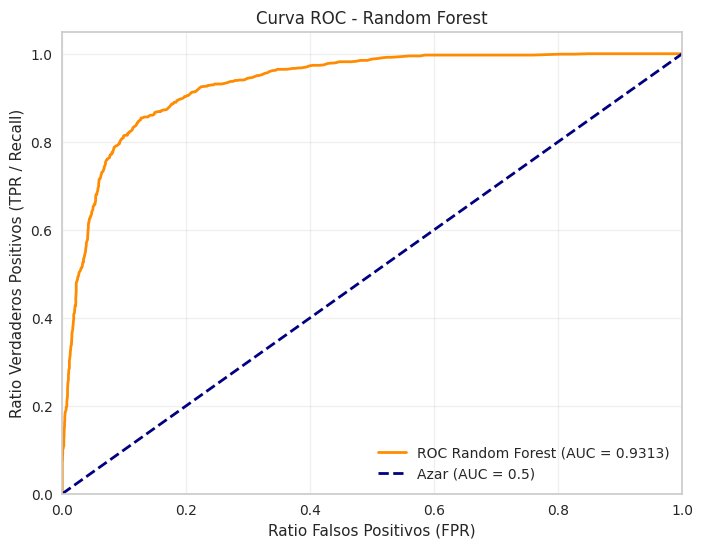

In [ ]:
# Curva ROC-AUC
auc_score = plot_custom_roc_curve(rf_clf, X_test_scaled, y_test,
                                    pos_label=1, model_name='Random Forest')

An AUC value of 0.93 indicates excellent model performance, as the model achieves a high true positive rate while maintaining a low false positive rate.

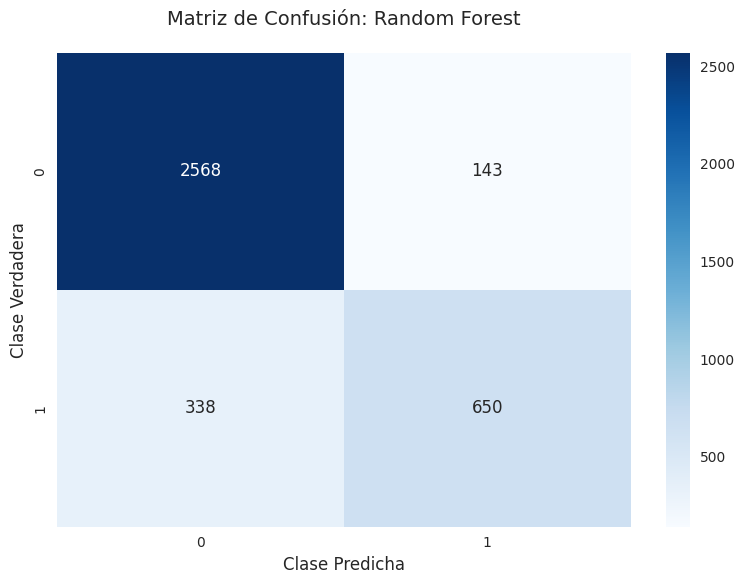

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf_clf, rf_clf.classes_, "Random Forest")

The confusion matrix reveals a moderate classification performance for class 1, with approximately 66% of the instances correctly identified. In contrast, the model demonstrates very strong performance for class 0, with only about 5% of non-epitope instances incorrectly classified as epitopes.

## Random Forest GSCV

In [ ]:
# Defino la grilla de parámetros para Random Forest
param_grid_rf = {
    'n_estimators': [150, 300, 450],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

print("Iniciando GridSearchCV para Random Forest...")
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='f1',
                              n_jobs=-1,
                              verbose=2)

start_time_grid_search = time.time()
grid_search_rf.fit(X_train_scaled, y_train)
end_time_grid_search = time.time()

rf_gscv_train_time = end_time_grid_search - start_time_grid_search

print("\n--- Resultados de GridSearchCV (Random Forest) ---")
print(f"Mejores hiperparámetros encontrados: {grid_search_rf.best_params_}")
print(f"Mejor puntuación (precisión) en validación cruzada: {grid_search_rf.best_score_:.4f}")

best_rf_model = grid_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test_scaled)

report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
f1_score_rf_weighted = report_rf['weighted avg']['f1-score']
print(f"F1-score (weighted avg): {f1_score_rf_weighted:.4f}")
print("\n\n\nReporte de clasificación (Random Forest GSCV - Test):")
print(classification_report(y_test, y_pred_rf))

model_results['Random Forest (GSCV)'] = {
    'Recall': recall_score(y_test, y_pred_rf),
    'F1_Score_Weighted': f1_score_rf_weighted,
    'Train_Time_s': rf_gscv_train_time
}

Iniciando GridSearchCV para Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- Resultados de GridSearchCV (Random Forest) ---
Mejores hiperparámetros encontrados: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}
Mejor puntuación (precisión) en validación cruzada: 0.7315
F1-score (weighted avg): 0.8702



Reporte de clasificación (Random Forest GSCV - Test):
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2711
           1       0.77      0.74      0.75       988

    accuracy                           0.87      3699
   macro avg       0.84      0.83      0.83      3699
weighted avg       0.87      0.87      0.87      3699



The best model obtained through GridSearchCV achieved an improvement in the recall of class 1 compared to the previously trained Random Forest model; however, this improvement came at the cost of a decrease in precision. Overall, the F1-score increased by approximately 2%, indicating a better balance between precision and recall for the positive class.

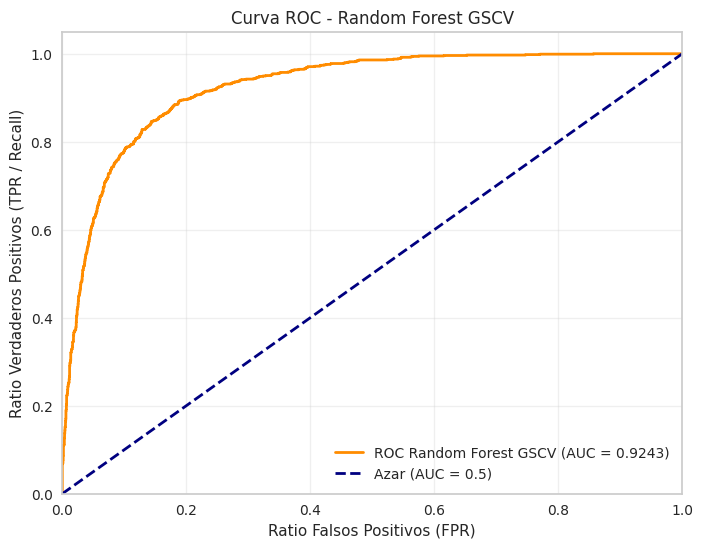

In [ ]:
# Curva ROC-AUC
auc_score = plot_custom_roc_curve(best_rf_model, X_test_scaled, y_test,
                                    pos_label=1, model_name='Random Forest GSCV')

The AUC value of this model remains nearly unchanged compared to the previously trained Random Forest model, showing only a 1% decrease, while still maintaining a very high overall performance level.

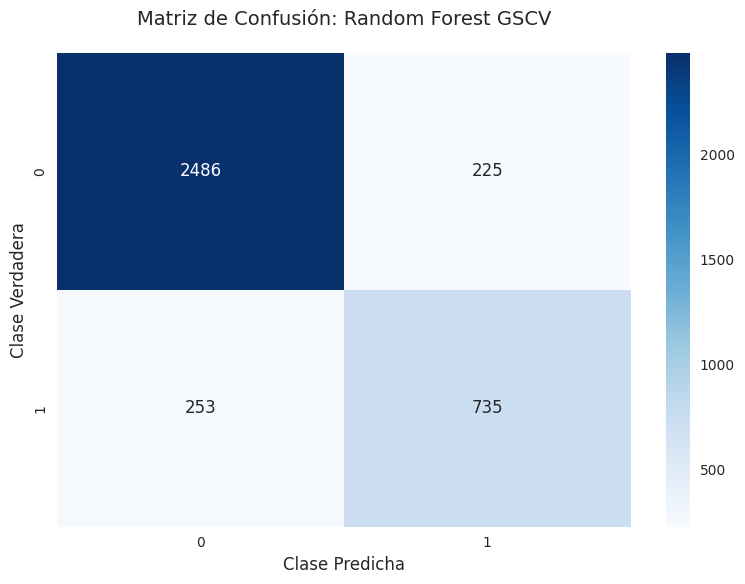

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf, best_rf_model.classes_, "Random Forest GSCV")

From the confusion matrix, it can be observed that this model achieves a better classification performance for class 1 compared to the previously trained Random Forest model. In this case, approximately 75% of the class 1 instances were correctly predicted. For class 0, around 8% of the observations were incorrectly classified as class 1, representing an increase of 3% relative to the previous model.

/tmp/ipython-input-4095521161.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




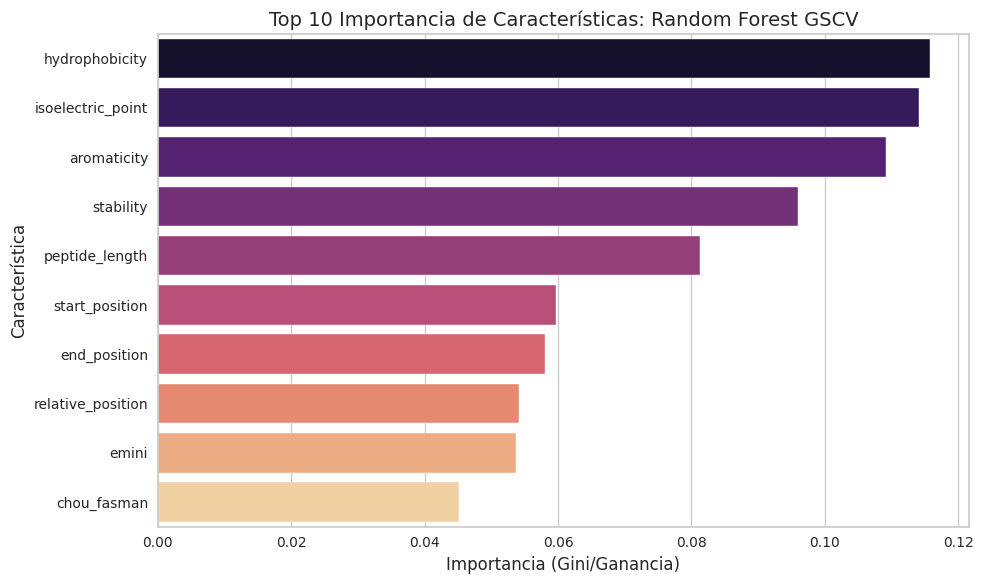


Características (ordenadas por importancia) para Random Forest GSCV:
             Feature  Importance
0     hydrophobicity    0.115832
1  isoelectric_point    0.114090
2        aromaticity    0.109184
3          stability    0.096040
4     peptide_length    0.081261
5     start_position    0.059728
6       end_position    0.058041
7  relative_position    0.054097
8              emini    0.053656
9        chou_fasman    0.045191


In [ ]:
# Top 10 features mas importantes para el modelo obtenido
rf_importances = plot_all_feature_importances(model=best_rf_model, feature_names=X_train.columns, top_n=10, model_name='Random Forest GSCV')

## XGBoost GSCV

In [ ]:
param_grid_xgb = {
    "n_estimators": [300, 600],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "gamma": [0, 0.5],
}

print("Iniciando GridSearchCV para XGBoost...")

xgb_base = XGBClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

grid_search_xgb = GridSearchCV(estimator=xgb_base, param_grid=param_grid_xgb, cv=5,
                                scoring="f1",
                                n_jobs=-1,
                                verbose=2
)

start_time_grid_search = time.time()
grid_search_xgb.fit(X_train_scaled, y_train)
end_time_grid_search = time.time()

xgb_gscv_train_time = end_time_grid_search - start_time_grid_search

print("\n--- Resultados de GridSearchCV (XGBoost) ---")
print(f"Mejores hiperparámetros encontrados: {grid_search_xgb.best_params_}")
print(f"Mejor puntuación (F1) en validación cruzada: {grid_search_xgb.best_score_:.4f}")

best_xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb_model.predict(X_test_scaled)

report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
f1_score_xgb_weighted = report_xgb["weighted avg"]["f1-score"]
recall_xgb_pos = report_xgb["1"]["recall"]  # recall de la clase 1

print(f"F1-score (weighted avg): {f1_score_xgb_weighted:.4f}")
print(f"Recall (clase 1): {recall_xgb_pos:.4f}")
print("\n\n\nReporte de clasificación (XGBoost GSCV - Test):")
print(classification_report(y_test, y_pred_xgb))

model_results["XGBoost (GSCV)"] = {
    "Recall": recall_xgb_pos,
    "F1_Score_Weighted": f1_score_xgb_weighted,
    "Train_Time_s": xgb_gscv_train_time
}


Iniciando GridSearchCV para XGBoost...
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[19:58:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.





--- Resultados de GridSearchCV (XGBoost) ---
Mejores hiperparámetros encontrados: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 600, 'subsample': 1.0}
Mejor puntuación (F1) en validación cruzada: 0.7290
F1-score (weighted avg): 0.8665
Recall (clase 1): 0.6832



Reporte de clasificación (XGBoost GSCV - Test):
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2711
           1       0.80      0.68      0.74       988

    accuracy                           0.87      3699
   macro avg       0.85      0.81      0.83      3699
weighted avg       0.87      0.87      0.87      3699



The performance metrics obtained using XGBoost with GridSearchCV were very similar to those achieved by the initial Random Forest model.

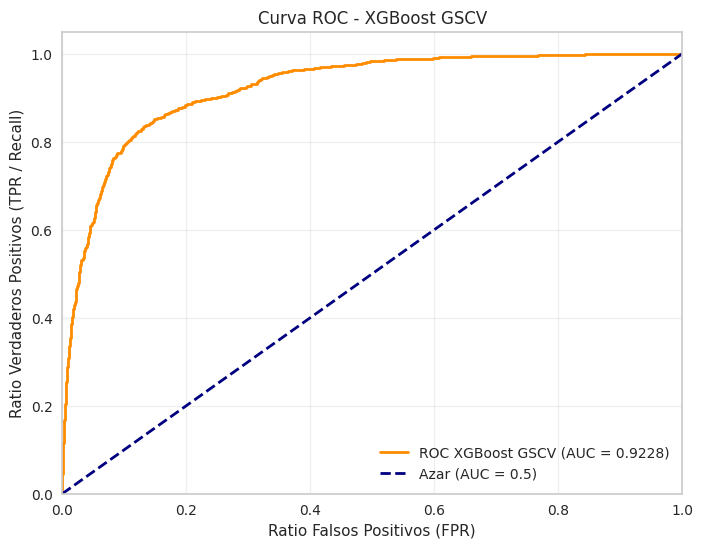

In [ ]:
# Curva ROC-AUC
auc_score = plot_custom_roc_curve(best_xgb_model, X_test_scaled, y_test,
                                    pos_label=1, model_name='XGBoost GSCV')

The AUC value is very similar to that obtained with the Random Forest optimized via GridSearchCV, indicating an excellent balance between the true positive rate and the false positive rate.

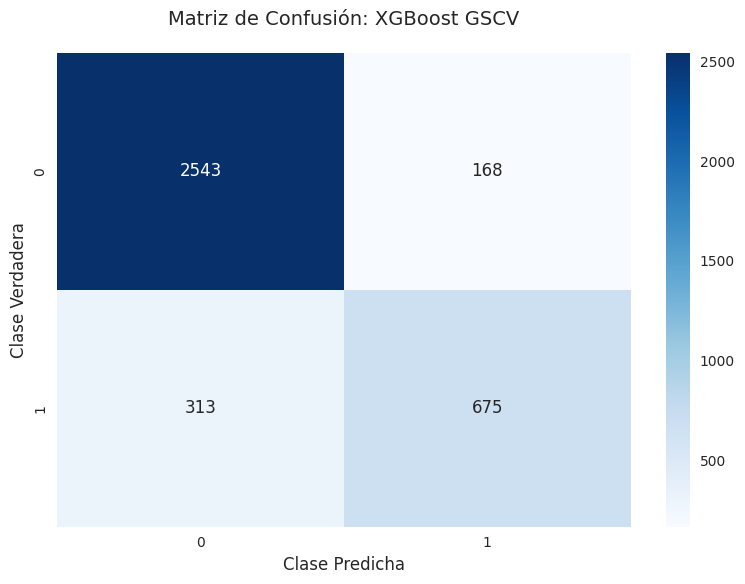

In [ ]:
plot_confusion_matrix(y_test, y_pred_xgb, best_xgb_model.classes_, "XGBoost GSCV")

The confusion matrix closely resembles that of the initial Random Forest model.

# Multi Layer Perceptron

The performance of a multilayer perceptron (MLP) will be evaluated to determine whether it can compete with or outperform the Random Forest optimized via GridSearchCV.

In [ ]:
# Genero un df para la seccion MLP
df_mlp = df_clean.copy()

In [ ]:
# Agrego los clusters generados en la seccion HC
df_mlp['hc_complete'] = df_hier_clust['hc_complete']
df_mlp = df_mlp.drop(['parent_protein_id', 'protein_seq', 'peptide_seq'], axis=1)
df_mlp.head(3)

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,peptide_length,hydrophobic_ratio,flexible_ratio,aromatic_ratio,relative_position,parker_per_aa,hc_complete
68,321,326,0.832,0.645,1.083,0.250,4.868713,0.027273,0.008909,32.973091,1,6,0.500000,0.000000,0.000000,0.583636,0.041667,0
69,268,273,0.930,0.757,1.027,0.050,5.810364,0.103275,-0.143829,40.273300,1,6,0.500000,0.000000,0.166667,0.675063,0.008333,0
70,385,390,0.775,0.228,1.140,-0.467,5.810364,0.103275,-0.143829,40.273300,1,6,0.666667,0.166667,0.166667,0.969773,-0.077833,0


In [ ]:
#Grid Search
mlp = MLPClassifier(solver="adam",
                max_iter=300,
                early_stopping=True,
                validation_fraction=0.15,
                n_iter_no_change=20,
                tol=1e-4,
                random_state=42,)

# Definicion de hiperparametros
param_grid_mlp = {
    "hidden_layer_sizes": [(128, 64, 32),(128, 128, 64), (256, 128, 64)],
    "activation": ["relu"],
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [5e-4, 1e-3, 3e-3],
    "batch_size": [64, 128],
}

grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, scoring='f1', cv=5, n_jobs=-1, verbose=2, refit=True)

start_time_grid_search = time.time()
grid_search_mlp.fit(X_train_scaled, y_train)
end_time_grid_search = time.time()
mlp_gscv_train_time = end_time_grid_search - start_time_grid_search

y_pred_mlp_best = grid_search_mlp.predict(X_test_scaled)

print(f"Tiempo de entrenamiento (MLP Best Params): {mlp_gscv_train_time:.4f} segundos")
print("\n\n\nReporte de clasificación (MLP Best Params - Test):")
print(classification_report(y_test, y_pred_mlp_best))

# Obtener el classification report para calcular el F1-score
report_mlp_best = classification_report(y_test, y_pred_mlp_best, output_dict=True)
f1_score_mlp_best_weighted = report_mlp_best['weighted avg']['f1-score']

# Guardamos los resultados y tiempo de entrenamiento en nuestro diccionario
model_results['MLP (Best Params)'] = {
    'Recall': recall_score(y_test, y_pred_mlp_best),
    'F1_Score_Weighted': f1_score_mlp_best_weighted,
    'Train_Time_s': mlp_gscv_train_time
}
best_params_grid = grid_search_mlp.best_params_

print(best_params_grid)
print(f"Tiempo total de ejecución de GridSearchCV: {mlp_gscv_train_time:.4f} segundos")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Tiempo de entrenamiento (MLP Best Params): 2882.4988 segundos



Reporte de clasificación (MLP Best Params - Test):
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2711
           1       0.68      0.65      0.67       988

    accuracy                           0.83      3699
   macro avg       0.78      0.77      0.77      3699
weighted avg       0.82      0.83      0.82      3699

{'activation': 'relu', 'alpha': 1e-05, 'batch_size': 64, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.003}
Tiempo total de ejecución de GridSearchCV: 2882.4988 segundos


The performance metrics are lower for both classes compared to those obtained with the Random Forest and XGBoost models.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



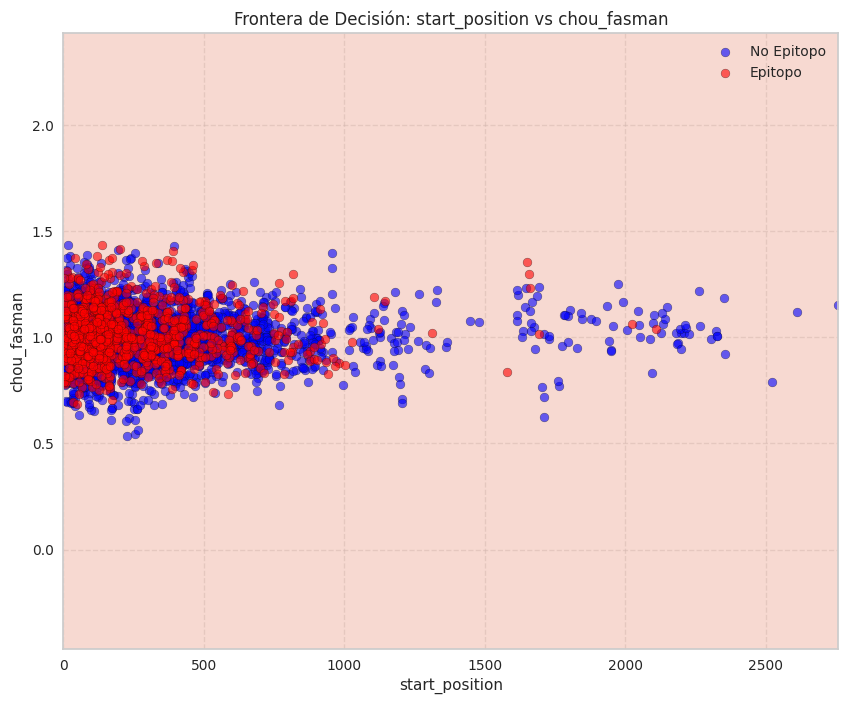

In [ ]:
plot_decision_boundary(grid_search_mlp, X_test, y_test, f1_idx=0, f2_idx=2, scaler=scaler)

No clear decision boundary can be distinguished between the two classes.

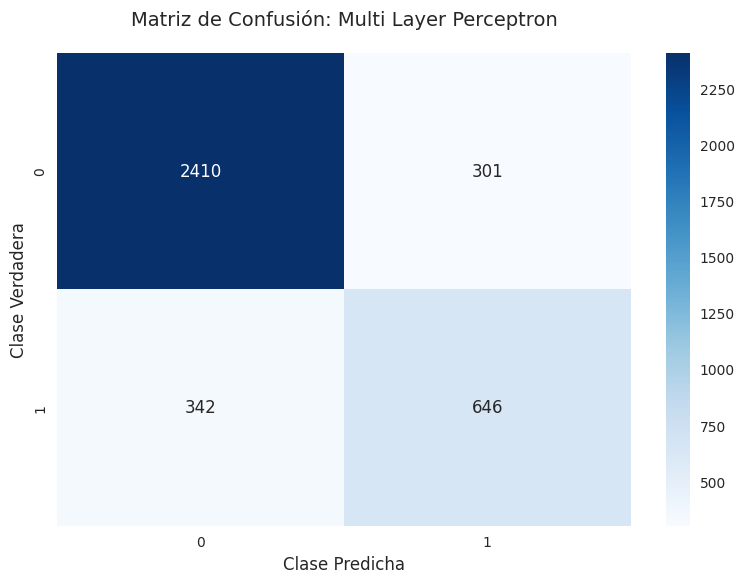

In [ ]:
plot_confusion_matrix(y_test, y_pred_mlp_best, grid_search_mlp.classes_, "Multi Layer Perceptron")

The confusion matrix shows a decrease in classification precision for both classes compared to the results obtained with the Random Forest and XGBoost models.

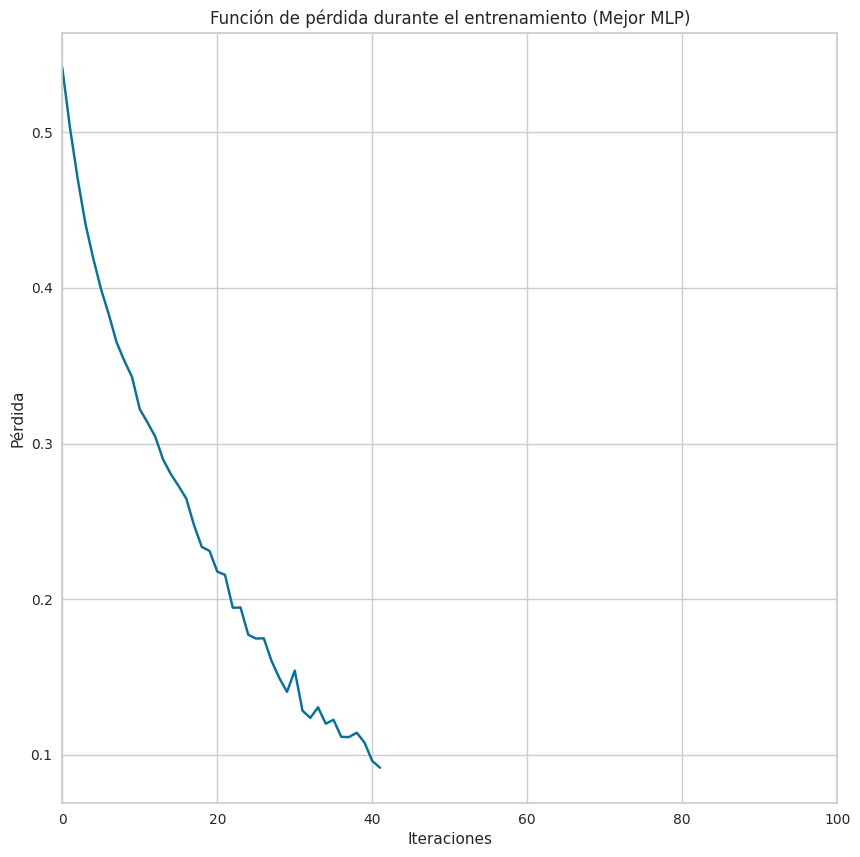

In [ ]:
#Graficar la función de pérdida del mejor modelo MLP
plt.figure(figsize=(10, 10))
plt.plot(grid_search_mlp.best_estimator_.loss_curve_)
plt.title('Función de pérdida durante el entrenamiento (Mejor MLP)')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.xlim(0, 60)
plt.show()

The model stops after approximately 40 iterations, due to the early stopping criterion.

# Model Comparison

The performance of the evaluated models is compared in terms of their ability to correctly identify epitopes, with particular emphasis on recall, F1-score, and AUC, in order to assess the trade-offs between sensitivity and overall classification performance.

In [ ]:
# Convertir el diccionario model_results a un df para facilitar la visualización
results_df = pd.DataFrame.from_dict(model_results, orient='index')

/tmp/ipython-input-2226562581.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




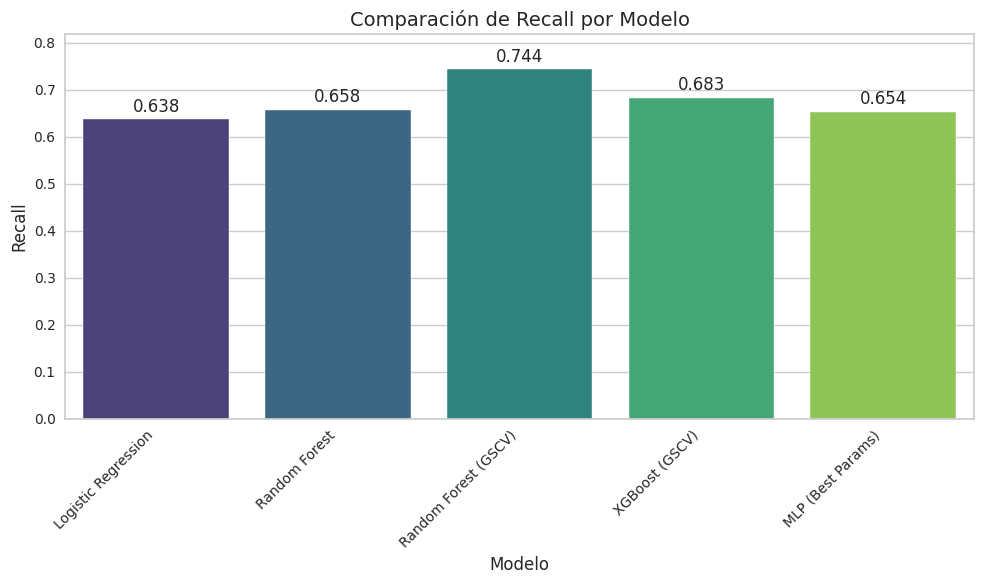

In [ ]:
plot_model_comparison(results_df, metric='Recall')

In this bar chart, it can be observed that the Random Forest optimized via GridSearchCV achieved the highest recall, outperforming the other models by 6% or more.

/tmp/ipython-input-2226562581.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




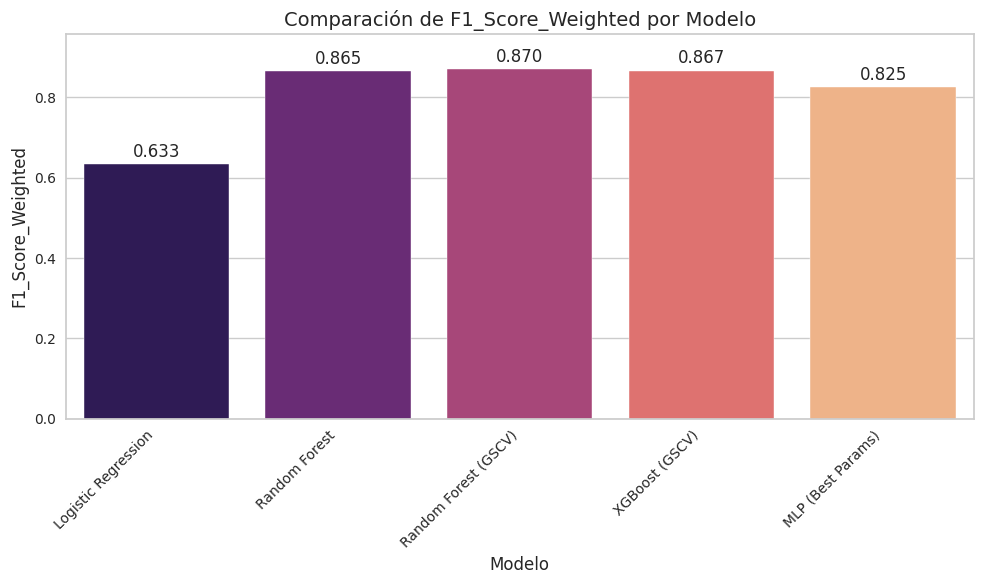

In [ ]:
plot_model_comparison(results_df, metric='F1_Score_Weighted', color_palette='magma')

Regarding the average F1-score, no substantial differences are observed between the standard Random Forest, Random Forest optimized via GridSearchCV, and XGBoost models. The MLP performs slightly below these three approaches, while Logistic Regression shows a markedly lower performance compared to the remaining models.

/tmp/ipython-input-2226562581.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




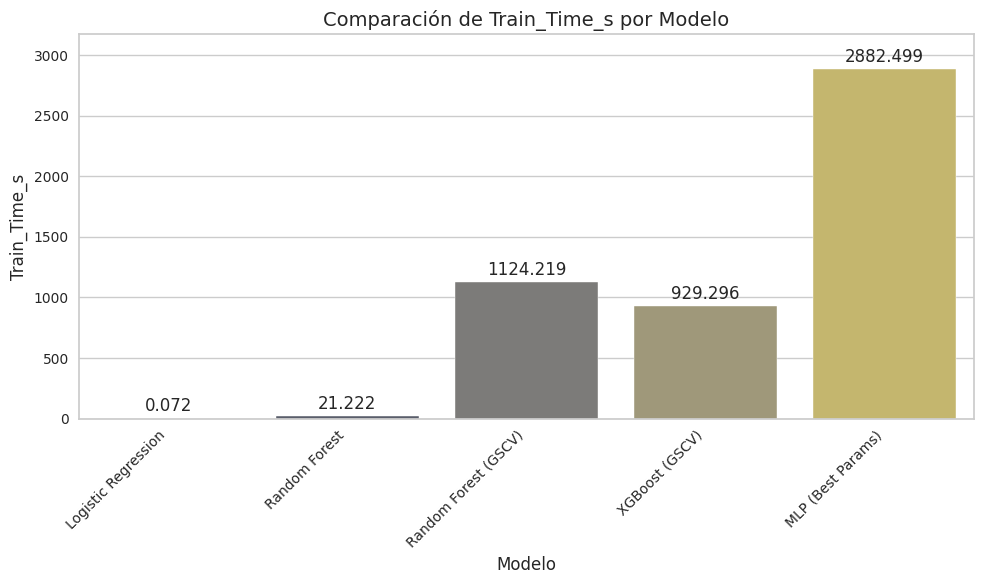

In [ ]:
plot_model_comparison(results_df, metric='Train_Time_s', color_palette='cividis')

The model with the longest training time was the MLP optimized via GridSearchCV, followed by Random Forest with GridSearchCV and XGBoost with GridSearchCV. The Random Forest optimized via GridSearchCV required nearly 19 minutes of training time, representing a substantial increase when compared to the standard Random Forest model.

# Results

## EDA

- Six new variables were engineered as part of the exploratory analysis.

- The target feature exhibits a moderately imbalanced distribution, with approximately 27% epitopes and 73% non-epitopes.

- Features related to surface accessibility (such as emini and parker) display asymmetric distributions with long tails toward extreme values.

- Extreme values observations do not represent measurement errors, as they fall within biologically plausible ranges. Instead, higher values correspond to highly exposed regions, which may be particularly relevant from an immunological perspective.

- Features associated with flexibility and hydrophobicity show a high degree of variability, indicating that epitopes do not constitute a homogeneous group in terms of physicochemical properties.

- No strong multicollinearity is observed among the main variables. However, some features exhibit relationships that are consistent with biochemical expectations, such as the association between hydrophobicity and surface accessibility.


## Clusterizacion Jerarquica

A traves del Clusterizado Jerarquico pudimos dilucidar una estructura de los datos que se divide en 4 clusters. Cabe destacar:

- En este caso el Metodo utilizado fue el Completo y la distancia Euclideanas.
- Un cluster está compuesto por un 40% de epitopos. En esta clase se distinguen diferencias importantes en las variables parker e hydrophobicity.
- Uno de los clusters solo tiene 1 integrante, por lo cual creo que es importante indagar sobre la naturaleza de este dato en particular, para ver si corresponde a un outlier, fue un fallo en la medicion o puede ser un candidato importante a estudiar por sus caracteristicas particulares como epitopo.
- Se creó una nueva variable en base a esta categorizacion para ser utilizada en los modelos supervisados.

## Classiffication Model

Several models were evaluated, including Logistic Regression, Random Forest, Random Forest optimized via GridSearchCV, XGBoost optimized via GridSearchCV, and a Multilayer Perceptron (MLP). Based on the objective of the proposed problem, priority was given to the recall of the positive class (epitopes), aiming to minimize the loss of true epitopes that may be immunologically relevant.

The models that achieved the best performance metrics are summarized below.

Top-Performing Models

- First, the Random Forest optimized via GridSearchCV achieved the best overall performance, with a recall of 0.744, an average F1-score of 0.87, and an AUC of 0.92. This model demonstrated the strongest capability for correctly identifying the positive class corresponding to epitopes. However, it also represents the second most computationally expensive model, requiring approximately 1124 seconds of training time.

- Second, the XGBoost optimized via GridSearchCV achieved a recall of 0.683, an average F1-score of 0.867, and an AUC of 0.92. In terms of computational cost, it ranks as the third most resource-intensive model, with a training time of approximately 929 seconds, which is around 200 seconds less than the Random Forest optimized via GridSearchCV.

- Third, the standard Random Forest model demonstrated performance comparable to that of XGBoost optimized via GridSearchCV while requiring significantly fewer computational resources. With a recall of 0.658, an average F1-score of 0.865, and an AUC of 0.93, this model achieves nearly equivalent predictive performance, offering a favorable trade-off between accuracy and efficiency.

Multilayer Perceptron Performance

The MLP model did not achieve competitive performance metrics and was, by a large margin, the most computationally expensive model evaluated. Its lower performance suggests that, for this dataset, tree-based models are more effective at capturing the relevant non-linear relationships present in the data.

Feature Importance Analysis

From the best-performing model (Random Forest optimized via GridSearchCV), the most important features identified were:

- hydrophobicity

- isoelectric_point

- aromaticity

- stability

- peptide_length

These features highlight the relevance of physicochemical properties and peptide length in the prediction of B-cell epitopes.

# Final Conclusion

The Random Forest model optimized via GridSearchCV is considered the most appropriate approach for implementation in epitope prediction, as it provides the best overall balance between sensitivity and predictive performance for the positive class.

In scenarios where computational resources and training time are a limiting factor, the standard Random Forest model represents a strong alternative, delivering competitive performance while requiring significantly fewer resources.

Although the selected model performs effectively in identifying potential epitope candidates—thereby reducing experimental time and laboratory costs—there remains room for further improvement. Future work could focus on more extensive feature engineering, exploring additional hyperparameter combinations, or incorporating epitope data from viruses closely related to SARS-CoV-2. Such extensions may help mitigate class imbalance and further enhance the model’s generalization capability.

Overall, this study demonstrates that machine learning models, particularly tree-based ensembles combined with biologically informed features, constitute a robust and efficient framework for the computational prioritization of B-cell epitopes.

